# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

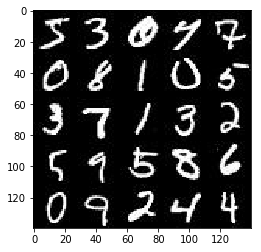

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

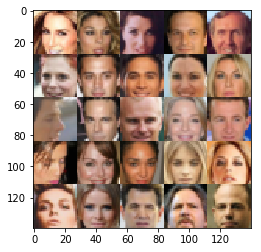

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels ))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [3]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        h = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu = tf.maximum(alpha * h, h)
        # 14x14x64
        h = tf.layers.conv2d(relu, 128, 5, strides=2, padding='same')
        bn = tf.layers.batch_normalization(h, training=True)
        relu = tf.maximum(alpha * bn, bn)
        # 7x7x128
        h = tf.layers.conv2d(relu, 256, 5, strides=1, padding='same')
        bn = tf.layers.batch_normalization(h, training=True)
        relu = tf.maximum(alpha * bn, bn)
        # 7x7x256
        flat = tf.reshape(relu, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2

    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        h = tf.layers.dense(z, 7*7*256)
        h = tf.reshape(h, (-1, 7, 7, 256))
        bn = tf.layers.batch_normalization(h, training=is_train)
        relu = tf.maximum(alpha * bn, bn)
        # 7x7x256
        h = tf.layers.conv2d_transpose(relu, 128, 5, strides=1, padding='same')
        bn = tf.layers.batch_normalization(h, training=is_train)
        relu = tf.maximum(alpha * bn, bn)
        # 7x7x128
        h = tf.layers.conv2d_transpose(relu, 64, 5, strides=2, padding='same')
        bn = tf.layers.batch_normalization(h, training=is_train)
        relu = tf.maximum(alpha * bn, bn)
        # 14x14x64
        h = tf.layers.conv2d_transpose(relu, out_channel_dim, 5, strides=2, padding='same')
        # 28x28 x out_channel_dim
        logits = h
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [5]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    real_output, real_logits = discriminator(input_real)
    fake_output, fake_logits = discriminator(g_output, reuse=True)
    
    # 计算d-loss ->使discriminator的输出：fake=0 && real=1
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_logits, labels=tf.zeros_like(fake_output)))
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=real_logits, labels=tf.ones_like(real_output)))
    
    d_loss = d_loss_fake + d_loss_real   
    
    # 计算g-loss ->使generator输出到discriminator后判断：fake=1
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=fake_logits, labels=tf.ones_like(fake_output)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    #    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    # 参考链接：https://github.com/TokyoIndex/dlnd_face_generation
    
    tf_update_collection = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in tf_update_collection if opt.name.startswith('discriminator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    g_updates = [opt for opt in tf_update_collection if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [8]:
import helper
from glob import glob
import os
from matplotlib import pyplot
data_dir = './data'
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))


In [9]:
print(mnist_dataset.image_mode)
print(mnist_dataset.shape[2])

L
28


In [10]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input_images, z_data, learning_rate_p = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_j=0
            for batch_images in get_batches(batch_size):
                #from max=0.5 to max=1
                batch_images = batch_images*2
                # TODO: Train Model
                input_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_input_images:batch_images, z_data:input_z, learning_rate_p:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_input_images:batch_images, z_data:input_z, learning_rate_p:learning_rate})
                
                if batch_j%100==0:
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
                
                if batch_j%10==0:
                    d_loss_train = d_loss.eval(feed_dict={real_input_images:batch_images, z_data:input_z})
                    g_loss_train = g_loss.eval(feed_dict={z_data:input_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "batch {}...".format(batch_j),
                          "Discriminator Loss: {:.4f}...".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                batch_j += 1   


### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

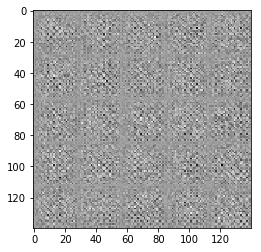

Epoch 1/2... batch 0... Discriminator Loss: 2.7464... Generator Loss: 0.0890
Epoch 1/2... batch 10... Discriminator Loss: 0.3148... Generator Loss: 2.6472
Epoch 1/2... batch 20... Discriminator Loss: 0.4624... Generator Loss: 4.7653
Epoch 1/2... batch 30... Discriminator Loss: 2.0978... Generator Loss: 5.9077
Epoch 1/2... batch 40... Discriminator Loss: 1.0497... Generator Loss: 0.9461
Epoch 1/2... batch 50... Discriminator Loss: 0.6789... Generator Loss: 1.2200
Epoch 1/2... batch 60... Discriminator Loss: 0.2783... Generator Loss: 2.3079
Epoch 1/2... batch 70... Discriminator Loss: 1.7737... Generator Loss: 0.4920
Epoch 1/2... batch 80... Discriminator Loss: 1.4215... Generator Loss: 0.4442
Epoch 1/2... batch 90... Discriminator Loss: 0.6364... Generator Loss: 1.5246


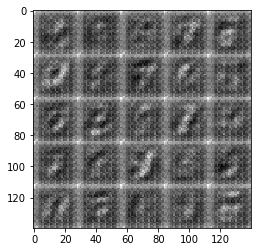

Epoch 1/2... batch 100... Discriminator Loss: 0.6792... Generator Loss: 1.2968
Epoch 1/2... batch 110... Discriminator Loss: 0.6172... Generator Loss: 1.2931
Epoch 1/2... batch 120... Discriminator Loss: 0.5996... Generator Loss: 1.6042
Epoch 1/2... batch 130... Discriminator Loss: 1.2293... Generator Loss: 0.5243
Epoch 1/2... batch 140... Discriminator Loss: 1.2064... Generator Loss: 3.2925
Epoch 1/2... batch 150... Discriminator Loss: 1.1653... Generator Loss: 0.4942
Epoch 1/2... batch 160... Discriminator Loss: 0.7412... Generator Loss: 1.1439
Epoch 1/2... batch 170... Discriminator Loss: 0.7055... Generator Loss: 1.7137
Epoch 1/2... batch 180... Discriminator Loss: 0.5128... Generator Loss: 1.4983
Epoch 1/2... batch 190... Discriminator Loss: 0.6262... Generator Loss: 2.3206


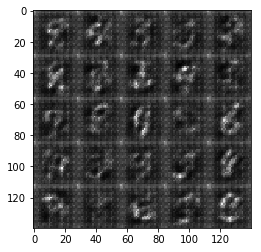

Epoch 1/2... batch 200... Discriminator Loss: 1.2457... Generator Loss: 0.5068
Epoch 1/2... batch 210... Discriminator Loss: 0.6041... Generator Loss: 1.3209
Epoch 1/2... batch 220... Discriminator Loss: 0.8656... Generator Loss: 1.2665
Epoch 1/2... batch 230... Discriminator Loss: 0.5062... Generator Loss: 1.3211
Epoch 1/2... batch 240... Discriminator Loss: 0.5584... Generator Loss: 2.1611
Epoch 1/2... batch 250... Discriminator Loss: 0.4893... Generator Loss: 1.7541
Epoch 1/2... batch 260... Discriminator Loss: 0.4519... Generator Loss: 2.1471
Epoch 1/2... batch 270... Discriminator Loss: 1.0441... Generator Loss: 0.6485
Epoch 1/2... batch 280... Discriminator Loss: 0.6834... Generator Loss: 3.0526
Epoch 1/2... batch 290... Discriminator Loss: 0.5718... Generator Loss: 1.2061


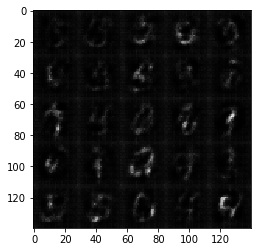

Epoch 1/2... batch 300... Discriminator Loss: 0.5020... Generator Loss: 1.3458
Epoch 1/2... batch 310... Discriminator Loss: 0.4846... Generator Loss: 1.4524
Epoch 1/2... batch 320... Discriminator Loss: 0.5872... Generator Loss: 2.0652
Epoch 1/2... batch 330... Discriminator Loss: 1.3621... Generator Loss: 0.4223
Epoch 1/2... batch 340... Discriminator Loss: 0.5220... Generator Loss: 1.3218
Epoch 1/2... batch 350... Discriminator Loss: 0.3716... Generator Loss: 1.7524
Epoch 1/2... batch 360... Discriminator Loss: 0.6960... Generator Loss: 0.9758
Epoch 1/2... batch 370... Discriminator Loss: 0.5549... Generator Loss: 2.9378
Epoch 1/2... batch 380... Discriminator Loss: 0.2915... Generator Loss: 2.4730
Epoch 1/2... batch 390... Discriminator Loss: 0.5908... Generator Loss: 1.2739


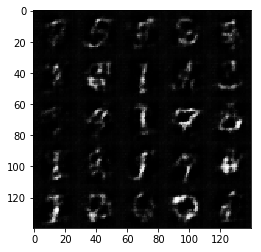

Epoch 1/2... batch 400... Discriminator Loss: 0.9320... Generator Loss: 3.0145
Epoch 1/2... batch 410... Discriminator Loss: 0.4703... Generator Loss: 2.0113
Epoch 1/2... batch 420... Discriminator Loss: 0.4474... Generator Loss: 2.0008
Epoch 1/2... batch 430... Discriminator Loss: 0.5319... Generator Loss: 1.4862
Epoch 1/2... batch 440... Discriminator Loss: 0.5563... Generator Loss: 1.1855
Epoch 1/2... batch 450... Discriminator Loss: 0.5095... Generator Loss: 1.2283
Epoch 1/2... batch 460... Discriminator Loss: 0.5518... Generator Loss: 1.2482
Epoch 1/2... batch 470... Discriminator Loss: 0.8813... Generator Loss: 0.8301
Epoch 1/2... batch 480... Discriminator Loss: 0.4181... Generator Loss: 1.6186
Epoch 1/2... batch 490... Discriminator Loss: 0.5903... Generator Loss: 1.2529


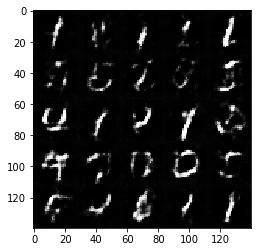

Epoch 1/2... batch 500... Discriminator Loss: 0.6107... Generator Loss: 1.1592
Epoch 1/2... batch 510... Discriminator Loss: 0.8435... Generator Loss: 3.4081
Epoch 1/2... batch 520... Discriminator Loss: 0.5687... Generator Loss: 2.6515
Epoch 1/2... batch 530... Discriminator Loss: 0.6507... Generator Loss: 1.0834
Epoch 1/2... batch 540... Discriminator Loss: 0.6726... Generator Loss: 0.9208
Epoch 1/2... batch 550... Discriminator Loss: 1.2056... Generator Loss: 0.5166
Epoch 1/2... batch 560... Discriminator Loss: 1.0819... Generator Loss: 3.7234
Epoch 1/2... batch 570... Discriminator Loss: 0.4295... Generator Loss: 2.1568
Epoch 1/2... batch 580... Discriminator Loss: 0.6573... Generator Loss: 0.9164
Epoch 1/2... batch 590... Discriminator Loss: 0.5111... Generator Loss: 1.7086


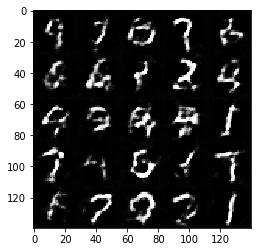

Epoch 1/2... batch 600... Discriminator Loss: 1.0466... Generator Loss: 0.5937
Epoch 1/2... batch 610... Discriminator Loss: 0.8003... Generator Loss: 1.0497
Epoch 1/2... batch 620... Discriminator Loss: 0.5470... Generator Loss: 1.6136
Epoch 1/2... batch 630... Discriminator Loss: 0.5655... Generator Loss: 1.4521
Epoch 1/2... batch 640... Discriminator Loss: 0.6125... Generator Loss: 1.1510
Epoch 1/2... batch 650... Discriminator Loss: 0.7416... Generator Loss: 1.5442
Epoch 1/2... batch 660... Discriminator Loss: 1.0712... Generator Loss: 0.6166
Epoch 1/2... batch 670... Discriminator Loss: 0.7407... Generator Loss: 2.6175
Epoch 1/2... batch 680... Discriminator Loss: 0.5136... Generator Loss: 2.4981
Epoch 1/2... batch 690... Discriminator Loss: 0.6606... Generator Loss: 1.0954


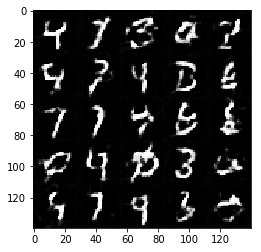

Epoch 1/2... batch 700... Discriminator Loss: 0.6839... Generator Loss: 1.1860
Epoch 1/2... batch 710... Discriminator Loss: 0.5931... Generator Loss: 1.2853
Epoch 1/2... batch 720... Discriminator Loss: 0.4709... Generator Loss: 2.1753
Epoch 1/2... batch 730... Discriminator Loss: 0.7763... Generator Loss: 0.8323
Epoch 1/2... batch 740... Discriminator Loss: 0.7903... Generator Loss: 0.8068
Epoch 1/2... batch 750... Discriminator Loss: 0.7125... Generator Loss: 0.9369
Epoch 1/2... batch 760... Discriminator Loss: 0.3618... Generator Loss: 1.7261
Epoch 1/2... batch 770... Discriminator Loss: 0.7452... Generator Loss: 1.1572
Epoch 1/2... batch 780... Discriminator Loss: 1.6304... Generator Loss: 4.1583
Epoch 1/2... batch 790... Discriminator Loss: 0.7747... Generator Loss: 1.6981


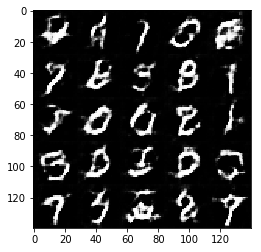

Epoch 1/2... batch 800... Discriminator Loss: 0.4527... Generator Loss: 1.8719
Epoch 1/2... batch 810... Discriminator Loss: 0.4838... Generator Loss: 1.3689
Epoch 1/2... batch 820... Discriminator Loss: 0.4854... Generator Loss: 1.2624
Epoch 1/2... batch 830... Discriminator Loss: 0.4544... Generator Loss: 1.4110
Epoch 1/2... batch 840... Discriminator Loss: 1.3259... Generator Loss: 0.3995
Epoch 1/2... batch 850... Discriminator Loss: 1.1601... Generator Loss: 0.5843
Epoch 1/2... batch 860... Discriminator Loss: 0.4341... Generator Loss: 2.2794
Epoch 1/2... batch 870... Discriminator Loss: 1.7409... Generator Loss: 0.5048
Epoch 1/2... batch 880... Discriminator Loss: 0.6124... Generator Loss: 1.6882
Epoch 1/2... batch 890... Discriminator Loss: 1.0609... Generator Loss: 0.6030


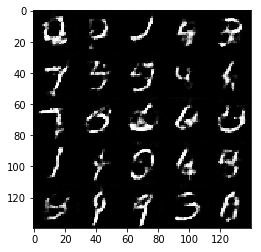

Epoch 1/2... batch 900... Discriminator Loss: 0.8575... Generator Loss: 0.7872
Epoch 1/2... batch 910... Discriminator Loss: 0.9684... Generator Loss: 0.6707
Epoch 1/2... batch 920... Discriminator Loss: 0.5219... Generator Loss: 1.2896
Epoch 1/2... batch 930... Discriminator Loss: 0.4786... Generator Loss: 1.6104


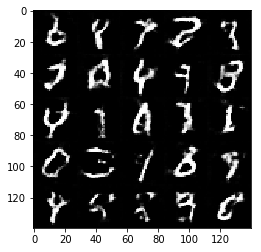

Epoch 2/2... batch 0... Discriminator Loss: 0.5928... Generator Loss: 1.1134
Epoch 2/2... batch 10... Discriminator Loss: 0.6353... Generator Loss: 1.0538
Epoch 2/2... batch 20... Discriminator Loss: 0.5986... Generator Loss: 1.2743
Epoch 2/2... batch 30... Discriminator Loss: 0.5625... Generator Loss: 1.3054
Epoch 2/2... batch 40... Discriminator Loss: 0.7787... Generator Loss: 0.8293
Epoch 2/2... batch 50... Discriminator Loss: 0.7902... Generator Loss: 0.7880
Epoch 2/2... batch 60... Discriminator Loss: 1.6390... Generator Loss: 0.3340
Epoch 2/2... batch 70... Discriminator Loss: 1.2713... Generator Loss: 0.4861
Epoch 2/2... batch 80... Discriminator Loss: 0.5065... Generator Loss: 1.3146
Epoch 2/2... batch 90... Discriminator Loss: 0.5406... Generator Loss: 1.1855


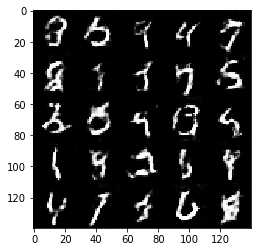

Epoch 2/2... batch 100... Discriminator Loss: 0.5080... Generator Loss: 1.2250
Epoch 2/2... batch 110... Discriminator Loss: 0.8890... Generator Loss: 0.6934
Epoch 2/2... batch 120... Discriminator Loss: 0.9669... Generator Loss: 0.6712
Epoch 2/2... batch 130... Discriminator Loss: 1.1969... Generator Loss: 0.4725
Epoch 2/2... batch 140... Discriminator Loss: 0.5390... Generator Loss: 1.5244
Epoch 2/2... batch 150... Discriminator Loss: 0.5067... Generator Loss: 1.3693
Epoch 2/2... batch 160... Discriminator Loss: 1.0596... Generator Loss: 0.5883
Epoch 2/2... batch 170... Discriminator Loss: 3.6114... Generator Loss: 0.0522
Epoch 2/2... batch 180... Discriminator Loss: 0.8043... Generator Loss: 1.5383
Epoch 2/2... batch 190... Discriminator Loss: 1.0813... Generator Loss: 0.8297


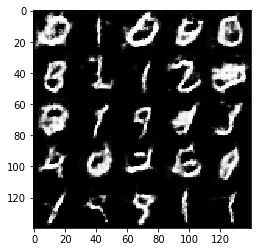

Epoch 2/2... batch 200... Discriminator Loss: 0.7405... Generator Loss: 1.3953
Epoch 2/2... batch 210... Discriminator Loss: 0.6280... Generator Loss: 1.1692
Epoch 2/2... batch 220... Discriminator Loss: 0.4670... Generator Loss: 1.6324
Epoch 2/2... batch 230... Discriminator Loss: 1.0671... Generator Loss: 0.6512
Epoch 2/2... batch 240... Discriminator Loss: 1.0097... Generator Loss: 1.5167
Epoch 2/2... batch 250... Discriminator Loss: 0.8128... Generator Loss: 1.6569
Epoch 2/2... batch 260... Discriminator Loss: 0.9161... Generator Loss: 0.7181
Epoch 2/2... batch 270... Discriminator Loss: 0.5824... Generator Loss: 1.2056
Epoch 2/2... batch 280... Discriminator Loss: 0.4961... Generator Loss: 1.4791
Epoch 2/2... batch 290... Discriminator Loss: 1.2401... Generator Loss: 0.4495


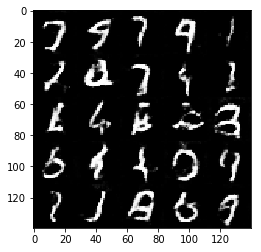

Epoch 2/2... batch 300... Discriminator Loss: 0.5009... Generator Loss: 1.5751
Epoch 2/2... batch 310... Discriminator Loss: 0.4659... Generator Loss: 1.4158
Epoch 2/2... batch 320... Discriminator Loss: 0.6478... Generator Loss: 1.0550
Epoch 2/2... batch 330... Discriminator Loss: 2.3880... Generator Loss: 0.1656
Epoch 2/2... batch 340... Discriminator Loss: 0.6240... Generator Loss: 1.6215
Epoch 2/2... batch 350... Discriminator Loss: 1.3753... Generator Loss: 0.4056
Epoch 2/2... batch 360... Discriminator Loss: 0.5809... Generator Loss: 1.2736
Epoch 2/2... batch 370... Discriminator Loss: 0.5931... Generator Loss: 1.0811
Epoch 2/2... batch 380... Discriminator Loss: 0.3904... Generator Loss: 1.4880
Epoch 2/2... batch 390... Discriminator Loss: 0.6071... Generator Loss: 1.0897


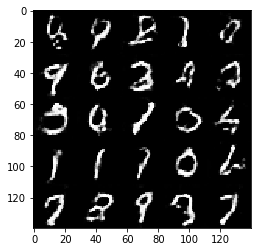

Epoch 2/2... batch 400... Discriminator Loss: 0.5399... Generator Loss: 1.2747
Epoch 2/2... batch 410... Discriminator Loss: 0.7371... Generator Loss: 0.9297
Epoch 2/2... batch 420... Discriminator Loss: 0.4059... Generator Loss: 1.5298
Epoch 2/2... batch 430... Discriminator Loss: 0.5539... Generator Loss: 1.3708
Epoch 2/2... batch 440... Discriminator Loss: 0.8627... Generator Loss: 0.7163
Epoch 2/2... batch 450... Discriminator Loss: 0.5183... Generator Loss: 1.1865
Epoch 2/2... batch 460... Discriminator Loss: 0.5558... Generator Loss: 1.1412
Epoch 2/2... batch 470... Discriminator Loss: 1.8079... Generator Loss: 4.2569
Epoch 2/2... batch 480... Discriminator Loss: 0.3072... Generator Loss: 2.1421
Epoch 2/2... batch 490... Discriminator Loss: 0.7298... Generator Loss: 0.9139


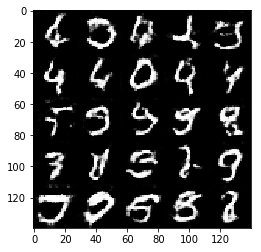

Epoch 2/2... batch 500... Discriminator Loss: 0.8210... Generator Loss: 0.8395
Epoch 2/2... batch 510... Discriminator Loss: 0.5268... Generator Loss: 1.4679
Epoch 2/2... batch 520... Discriminator Loss: 0.4721... Generator Loss: 2.6028
Epoch 2/2... batch 530... Discriminator Loss: 0.4955... Generator Loss: 1.6639
Epoch 2/2... batch 540... Discriminator Loss: 0.5537... Generator Loss: 1.1946
Epoch 2/2... batch 550... Discriminator Loss: 0.8670... Generator Loss: 0.7563
Epoch 2/2... batch 560... Discriminator Loss: 0.6823... Generator Loss: 0.9610
Epoch 2/2... batch 570... Discriminator Loss: 0.9381... Generator Loss: 3.3248
Epoch 2/2... batch 580... Discriminator Loss: 0.7336... Generator Loss: 1.7134
Epoch 2/2... batch 590... Discriminator Loss: 0.6937... Generator Loss: 0.9860


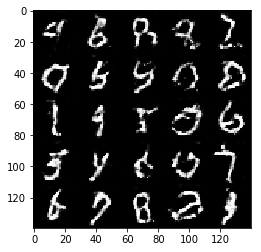

Epoch 2/2... batch 600... Discriminator Loss: 0.7234... Generator Loss: 0.8831
Epoch 2/2... batch 610... Discriminator Loss: 0.5599... Generator Loss: 1.1326
Epoch 2/2... batch 620... Discriminator Loss: 0.4961... Generator Loss: 1.3312
Epoch 2/2... batch 630... Discriminator Loss: 0.5038... Generator Loss: 1.4566
Epoch 2/2... batch 640... Discriminator Loss: 0.4005... Generator Loss: 1.7642
Epoch 2/2... batch 650... Discriminator Loss: 0.4556... Generator Loss: 2.0001
Epoch 2/2... batch 660... Discriminator Loss: 0.5263... Generator Loss: 1.8506
Epoch 2/2... batch 670... Discriminator Loss: 0.6245... Generator Loss: 1.1340
Epoch 2/2... batch 680... Discriminator Loss: 0.3999... Generator Loss: 1.5302
Epoch 2/2... batch 690... Discriminator Loss: 0.5539... Generator Loss: 1.2381


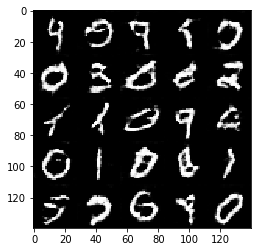

Epoch 2/2... batch 700... Discriminator Loss: 1.4567... Generator Loss: 0.3608
Epoch 2/2... batch 710... Discriminator Loss: 0.6996... Generator Loss: 1.0173
Epoch 2/2... batch 720... Discriminator Loss: 0.2302... Generator Loss: 2.7693
Epoch 2/2... batch 730... Discriminator Loss: 0.9679... Generator Loss: 0.6231
Epoch 2/2... batch 740... Discriminator Loss: 0.6244... Generator Loss: 2.1646
Epoch 2/2... batch 750... Discriminator Loss: 0.6315... Generator Loss: 1.1573
Epoch 2/2... batch 760... Discriminator Loss: 0.4809... Generator Loss: 1.4560
Epoch 2/2... batch 770... Discriminator Loss: 1.1895... Generator Loss: 0.5225
Epoch 2/2... batch 780... Discriminator Loss: 0.7145... Generator Loss: 3.4216
Epoch 2/2... batch 790... Discriminator Loss: 1.5320... Generator Loss: 0.3396


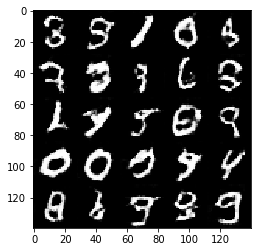

Epoch 2/2... batch 800... Discriminator Loss: 0.3933... Generator Loss: 1.5113
Epoch 2/2... batch 810... Discriminator Loss: 0.4272... Generator Loss: 1.4650
Epoch 2/2... batch 820... Discriminator Loss: 0.8643... Generator Loss: 0.7589
Epoch 2/2... batch 830... Discriminator Loss: 0.3152... Generator Loss: 1.8935
Epoch 2/2... batch 840... Discriminator Loss: 2.1287... Generator Loss: 0.1771
Epoch 2/2... batch 850... Discriminator Loss: 2.4761... Generator Loss: 0.1823
Epoch 2/2... batch 860... Discriminator Loss: 0.8954... Generator Loss: 3.9865
Epoch 2/2... batch 870... Discriminator Loss: 0.7393... Generator Loss: 1.9069
Epoch 2/2... batch 880... Discriminator Loss: 0.3745... Generator Loss: 2.2453
Epoch 2/2... batch 890... Discriminator Loss: 1.1861... Generator Loss: 0.6368


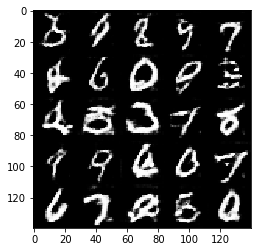

Epoch 2/2... batch 900... Discriminator Loss: 1.5535... Generator Loss: 0.3119
Epoch 2/2... batch 910... Discriminator Loss: 0.4590... Generator Loss: 2.3296
Epoch 2/2... batch 920... Discriminator Loss: 0.4298... Generator Loss: 1.5263
Epoch 2/2... batch 930... Discriminator Loss: 0.3906... Generator Loss: 1.5958


In [11]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

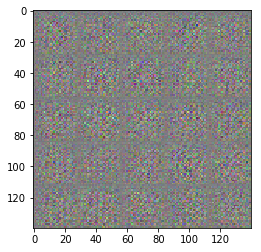

Epoch 1/1... batch 0... Discriminator Loss: 4.5423... Generator Loss: 0.0130
Epoch 1/1... batch 10... Discriminator Loss: 1.1681... Generator Loss: 0.5483
Epoch 1/1... batch 20... Discriminator Loss: 0.0818... Generator Loss: 6.1594
Epoch 1/1... batch 30... Discriminator Loss: 0.3122... Generator Loss: 1.7085
Epoch 1/1... batch 40... Discriminator Loss: 0.0965... Generator Loss: 9.6468
Epoch 1/1... batch 50... Discriminator Loss: 0.5238... Generator Loss: 1.8713
Epoch 1/1... batch 60... Discriminator Loss: 0.1464... Generator Loss: 5.9790
Epoch 1/1... batch 70... Discriminator Loss: 1.0892... Generator Loss: 3.4339
Epoch 1/1... batch 80... Discriminator Loss: 0.8529... Generator Loss: 1.0653
Epoch 1/1... batch 90... Discriminator Loss: 0.7461... Generator Loss: 1.1195


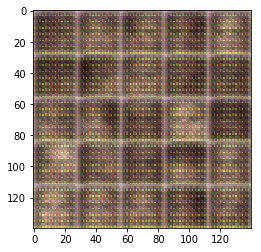

Epoch 1/1... batch 100... Discriminator Loss: 0.7646... Generator Loss: 0.9383
Epoch 1/1... batch 110... Discriminator Loss: 1.1030... Generator Loss: 0.5334
Epoch 1/1... batch 120... Discriminator Loss: 0.7798... Generator Loss: 1.1250
Epoch 1/1... batch 130... Discriminator Loss: 0.9177... Generator Loss: 0.7029
Epoch 1/1... batch 140... Discriminator Loss: 0.5343... Generator Loss: 1.4802
Epoch 1/1... batch 150... Discriminator Loss: 0.5991... Generator Loss: 1.2916
Epoch 1/1... batch 160... Discriminator Loss: 0.9433... Generator Loss: 0.7500
Epoch 1/1... batch 170... Discriminator Loss: 0.2770... Generator Loss: 2.4759
Epoch 1/1... batch 180... Discriminator Loss: 1.3807... Generator Loss: 0.4711
Epoch 1/1... batch 190... Discriminator Loss: 0.6387... Generator Loss: 1.3041


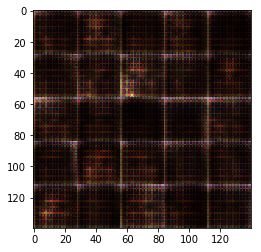

Epoch 1/1... batch 200... Discriminator Loss: 0.7499... Generator Loss: 0.9690
Epoch 1/1... batch 210... Discriminator Loss: 0.8959... Generator Loss: 1.1495
Epoch 1/1... batch 220... Discriminator Loss: 0.8573... Generator Loss: 0.8645
Epoch 1/1... batch 230... Discriminator Loss: 0.5157... Generator Loss: 2.2117
Epoch 1/1... batch 240... Discriminator Loss: 0.6437... Generator Loss: 1.2995
Epoch 1/1... batch 250... Discriminator Loss: 0.7737... Generator Loss: 1.2585
Epoch 1/1... batch 260... Discriminator Loss: 0.8558... Generator Loss: 0.7797
Epoch 1/1... batch 270... Discriminator Loss: 0.6480... Generator Loss: 1.2205
Epoch 1/1... batch 280... Discriminator Loss: 1.0540... Generator Loss: 0.7802
Epoch 1/1... batch 290... Discriminator Loss: 0.3978... Generator Loss: 1.9302


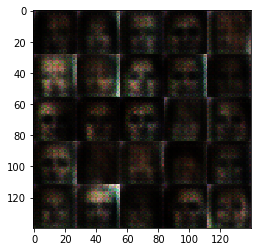

Epoch 1/1... batch 300... Discriminator Loss: 1.5961... Generator Loss: 0.3118
Epoch 1/1... batch 310... Discriminator Loss: 0.6036... Generator Loss: 1.8605
Epoch 1/1... batch 320... Discriminator Loss: 0.4660... Generator Loss: 1.9407
Epoch 1/1... batch 330... Discriminator Loss: 1.8527... Generator Loss: 2.7848
Epoch 1/1... batch 340... Discriminator Loss: 0.6564... Generator Loss: 2.2432
Epoch 1/1... batch 350... Discriminator Loss: 0.9059... Generator Loss: 1.0158
Epoch 1/1... batch 360... Discriminator Loss: 0.8628... Generator Loss: 1.0037
Epoch 1/1... batch 370... Discriminator Loss: 0.6353... Generator Loss: 1.2259
Epoch 1/1... batch 380... Discriminator Loss: 0.9486... Generator Loss: 0.8614
Epoch 1/1... batch 390... Discriminator Loss: 1.0183... Generator Loss: 0.6829


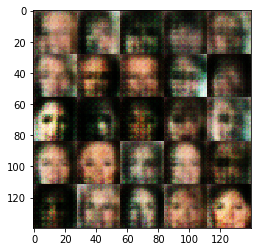

Epoch 1/1... batch 400... Discriminator Loss: 1.3753... Generator Loss: 0.4368
Epoch 1/1... batch 410... Discriminator Loss: 1.8328... Generator Loss: 0.2650
Epoch 1/1... batch 420... Discriminator Loss: 0.8922... Generator Loss: 1.4099
Epoch 1/1... batch 430... Discriminator Loss: 0.8349... Generator Loss: 1.4047
Epoch 1/1... batch 440... Discriminator Loss: 1.6935... Generator Loss: 0.4016
Epoch 1/1... batch 450... Discriminator Loss: 0.9752... Generator Loss: 1.1670
Epoch 1/1... batch 460... Discriminator Loss: 1.2258... Generator Loss: 2.6640
Epoch 1/1... batch 470... Discriminator Loss: 1.0946... Generator Loss: 1.8215
Epoch 1/1... batch 480... Discriminator Loss: 1.3185... Generator Loss: 0.4641
Epoch 1/1... batch 490... Discriminator Loss: 2.1260... Generator Loss: 0.1882


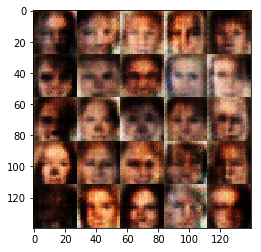

Epoch 1/1... batch 500... Discriminator Loss: 0.8352... Generator Loss: 1.1559
Epoch 1/1... batch 510... Discriminator Loss: 0.9764... Generator Loss: 0.7930
Epoch 1/1... batch 520... Discriminator Loss: 1.9477... Generator Loss: 0.2081
Epoch 1/1... batch 530... Discriminator Loss: 1.0442... Generator Loss: 2.0996
Epoch 1/1... batch 540... Discriminator Loss: 1.0586... Generator Loss: 0.9911
Epoch 1/1... batch 550... Discriminator Loss: 1.0129... Generator Loss: 0.7426
Epoch 1/1... batch 560... Discriminator Loss: 0.9842... Generator Loss: 2.0589
Epoch 1/1... batch 570... Discriminator Loss: 1.1479... Generator Loss: 0.8733
Epoch 1/1... batch 580... Discriminator Loss: 0.9023... Generator Loss: 1.1576
Epoch 1/1... batch 590... Discriminator Loss: 1.0903... Generator Loss: 0.9570


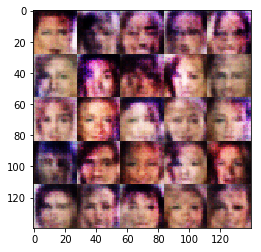

Epoch 1/1... batch 600... Discriminator Loss: 0.8916... Generator Loss: 1.3959
Epoch 1/1... batch 610... Discriminator Loss: 1.0432... Generator Loss: 2.0618
Epoch 1/1... batch 620... Discriminator Loss: 1.3082... Generator Loss: 2.1136
Epoch 1/1... batch 630... Discriminator Loss: 1.3913... Generator Loss: 0.4208
Epoch 1/1... batch 640... Discriminator Loss: 1.3297... Generator Loss: 0.4297
Epoch 1/1... batch 650... Discriminator Loss: 1.3930... Generator Loss: 0.4356
Epoch 1/1... batch 660... Discriminator Loss: 0.8919... Generator Loss: 1.0774
Epoch 1/1... batch 670... Discriminator Loss: 1.4157... Generator Loss: 0.4088
Epoch 1/1... batch 680... Discriminator Loss: 1.0994... Generator Loss: 1.6277
Epoch 1/1... batch 690... Discriminator Loss: 1.1183... Generator Loss: 0.7843


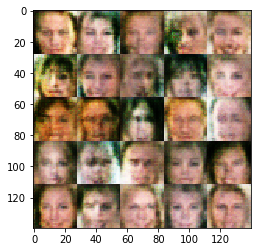

Epoch 1/1... batch 700... Discriminator Loss: 1.0471... Generator Loss: 0.8767
Epoch 1/1... batch 710... Discriminator Loss: 0.9793... Generator Loss: 0.9073
Epoch 1/1... batch 720... Discriminator Loss: 1.0267... Generator Loss: 0.6766
Epoch 1/1... batch 730... Discriminator Loss: 1.3598... Generator Loss: 0.4590
Epoch 1/1... batch 740... Discriminator Loss: 1.1564... Generator Loss: 0.6492
Epoch 1/1... batch 750... Discriminator Loss: 0.7819... Generator Loss: 1.0574
Epoch 1/1... batch 760... Discriminator Loss: 1.1933... Generator Loss: 0.5006
Epoch 1/1... batch 770... Discriminator Loss: 0.8118... Generator Loss: 1.1587
Epoch 1/1... batch 780... Discriminator Loss: 1.1706... Generator Loss: 0.9893
Epoch 1/1... batch 790... Discriminator Loss: 0.8561... Generator Loss: 0.8745


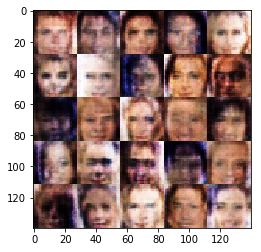

Epoch 1/1... batch 800... Discriminator Loss: 1.2708... Generator Loss: 0.4576
Epoch 1/1... batch 810... Discriminator Loss: 1.2425... Generator Loss: 0.4963
Epoch 1/1... batch 820... Discriminator Loss: 1.1188... Generator Loss: 2.3895
Epoch 1/1... batch 830... Discriminator Loss: 1.1858... Generator Loss: 0.5390
Epoch 1/1... batch 840... Discriminator Loss: 1.2273... Generator Loss: 0.7286
Epoch 1/1... batch 850... Discriminator Loss: 1.1622... Generator Loss: 0.6523
Epoch 1/1... batch 860... Discriminator Loss: 1.2146... Generator Loss: 1.4918
Epoch 1/1... batch 870... Discriminator Loss: 0.9988... Generator Loss: 0.8147
Epoch 1/1... batch 880... Discriminator Loss: 1.0388... Generator Loss: 1.5045
Epoch 1/1... batch 890... Discriminator Loss: 1.0097... Generator Loss: 1.1042


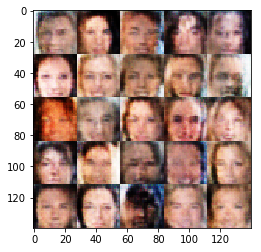

Epoch 1/1... batch 900... Discriminator Loss: 0.8926... Generator Loss: 1.5065
Epoch 1/1... batch 910... Discriminator Loss: 1.0390... Generator Loss: 0.7292
Epoch 1/1... batch 920... Discriminator Loss: 0.9170... Generator Loss: 0.8057
Epoch 1/1... batch 930... Discriminator Loss: 1.3530... Generator Loss: 1.7573
Epoch 1/1... batch 940... Discriminator Loss: 1.0607... Generator Loss: 0.7451
Epoch 1/1... batch 950... Discriminator Loss: 1.1482... Generator Loss: 0.6224
Epoch 1/1... batch 960... Discriminator Loss: 0.9366... Generator Loss: 1.5174
Epoch 1/1... batch 970... Discriminator Loss: 1.3307... Generator Loss: 0.4014
Epoch 1/1... batch 980... Discriminator Loss: 0.7946... Generator Loss: 1.3451
Epoch 1/1... batch 990... Discriminator Loss: 1.0749... Generator Loss: 0.6942


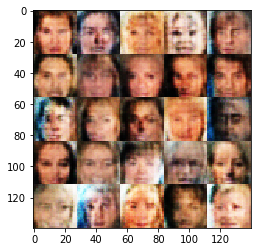

Epoch 1/1... batch 1000... Discriminator Loss: 1.2403... Generator Loss: 0.5305
Epoch 1/1... batch 1010... Discriminator Loss: 1.1183... Generator Loss: 0.6121
Epoch 1/1... batch 1020... Discriminator Loss: 0.9928... Generator Loss: 1.0522
Epoch 1/1... batch 1030... Discriminator Loss: 0.8483... Generator Loss: 0.7107
Epoch 1/1... batch 1040... Discriminator Loss: 1.1318... Generator Loss: 0.7669
Epoch 1/1... batch 1050... Discriminator Loss: 0.9400... Generator Loss: 0.7345
Epoch 1/1... batch 1060... Discriminator Loss: 0.9693... Generator Loss: 0.7524
Epoch 1/1... batch 1070... Discriminator Loss: 0.9992... Generator Loss: 0.7082
Epoch 1/1... batch 1080... Discriminator Loss: 0.9571... Generator Loss: 0.9765
Epoch 1/1... batch 1090... Discriminator Loss: 1.0501... Generator Loss: 1.0502


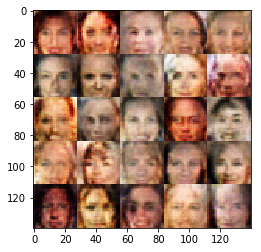

Epoch 1/1... batch 1100... Discriminator Loss: 0.7898... Generator Loss: 1.4426
Epoch 1/1... batch 1110... Discriminator Loss: 0.7689... Generator Loss: 1.5373
Epoch 1/1... batch 1120... Discriminator Loss: 1.1903... Generator Loss: 0.4771
Epoch 1/1... batch 1130... Discriminator Loss: 0.7655... Generator Loss: 1.4571
Epoch 1/1... batch 1140... Discriminator Loss: 0.7380... Generator Loss: 1.2360
Epoch 1/1... batch 1150... Discriminator Loss: 1.0168... Generator Loss: 0.9126
Epoch 1/1... batch 1160... Discriminator Loss: 1.1702... Generator Loss: 0.5959
Epoch 1/1... batch 1170... Discriminator Loss: 0.9740... Generator Loss: 1.2645
Epoch 1/1... batch 1180... Discriminator Loss: 0.8986... Generator Loss: 0.8510
Epoch 1/1... batch 1190... Discriminator Loss: 0.9050... Generator Loss: 0.9925


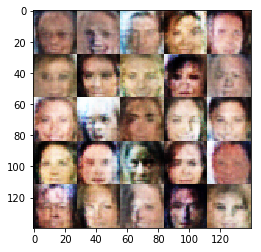

Epoch 1/1... batch 1200... Discriminator Loss: 0.8335... Generator Loss: 0.9076
Epoch 1/1... batch 1210... Discriminator Loss: 0.9151... Generator Loss: 1.0599
Epoch 1/1... batch 1220... Discriminator Loss: 0.6081... Generator Loss: 1.3313
Epoch 1/1... batch 1230... Discriminator Loss: 1.1634... Generator Loss: 0.5200
Epoch 1/1... batch 1240... Discriminator Loss: 1.2441... Generator Loss: 1.5446
Epoch 1/1... batch 1250... Discriminator Loss: 0.9339... Generator Loss: 1.0333
Epoch 1/1... batch 1260... Discriminator Loss: 0.8602... Generator Loss: 0.7461
Epoch 1/1... batch 1270... Discriminator Loss: 1.4078... Generator Loss: 0.3713
Epoch 1/1... batch 1280... Discriminator Loss: 0.8359... Generator Loss: 1.5448
Epoch 1/1... batch 1290... Discriminator Loss: 1.0129... Generator Loss: 0.6318


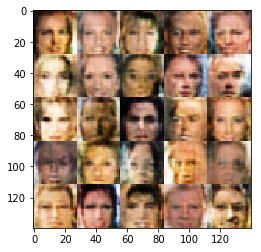

Epoch 1/1... batch 1300... Discriminator Loss: 1.0172... Generator Loss: 0.7656
Epoch 1/1... batch 1310... Discriminator Loss: 0.7977... Generator Loss: 0.9938
Epoch 1/1... batch 1320... Discriminator Loss: 1.2402... Generator Loss: 0.5463
Epoch 1/1... batch 1330... Discriminator Loss: 0.7796... Generator Loss: 0.9575
Epoch 1/1... batch 1340... Discriminator Loss: 1.0732... Generator Loss: 0.5724
Epoch 1/1... batch 1350... Discriminator Loss: 0.7973... Generator Loss: 0.9895
Epoch 1/1... batch 1360... Discriminator Loss: 0.9294... Generator Loss: 0.8826
Epoch 1/1... batch 1370... Discriminator Loss: 0.9253... Generator Loss: 1.2912
Epoch 1/1... batch 1380... Discriminator Loss: 1.0683... Generator Loss: 0.5479
Epoch 1/1... batch 1390... Discriminator Loss: 0.7747... Generator Loss: 1.0367


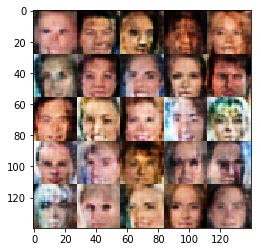

Epoch 1/1... batch 1400... Discriminator Loss: 0.8122... Generator Loss: 0.9927
Epoch 1/1... batch 1410... Discriminator Loss: 0.9594... Generator Loss: 0.7437
Epoch 1/1... batch 1420... Discriminator Loss: 0.9078... Generator Loss: 0.8330
Epoch 1/1... batch 1430... Discriminator Loss: 1.1876... Generator Loss: 0.6366
Epoch 1/1... batch 1440... Discriminator Loss: 1.3663... Generator Loss: 0.3906
Epoch 1/1... batch 1450... Discriminator Loss: 0.6719... Generator Loss: 1.5079
Epoch 1/1... batch 1460... Discriminator Loss: 1.0002... Generator Loss: 0.7296
Epoch 1/1... batch 1470... Discriminator Loss: 0.8570... Generator Loss: 0.8717
Epoch 1/1... batch 1480... Discriminator Loss: 1.3874... Generator Loss: 0.3963
Epoch 1/1... batch 1490... Discriminator Loss: 0.5138... Generator Loss: 1.4359


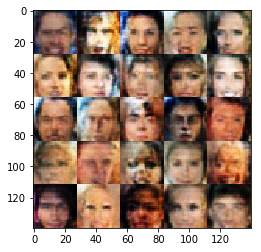

Epoch 1/1... batch 1500... Discriminator Loss: 1.6606... Generator Loss: 0.2803
Epoch 1/1... batch 1510... Discriminator Loss: 0.9676... Generator Loss: 1.5197
Epoch 1/1... batch 1520... Discriminator Loss: 0.8630... Generator Loss: 0.9896
Epoch 1/1... batch 1530... Discriminator Loss: 0.8971... Generator Loss: 1.1490
Epoch 1/1... batch 1540... Discriminator Loss: 1.8265... Generator Loss: 0.3004
Epoch 1/1... batch 1550... Discriminator Loss: 0.7841... Generator Loss: 1.3872
Epoch 1/1... batch 1560... Discriminator Loss: 1.1853... Generator Loss: 0.5137
Epoch 1/1... batch 1570... Discriminator Loss: 1.0010... Generator Loss: 0.6568
Epoch 1/1... batch 1580... Discriminator Loss: 1.0751... Generator Loss: 0.6304
Epoch 1/1... batch 1590... Discriminator Loss: 0.7693... Generator Loss: 0.8920


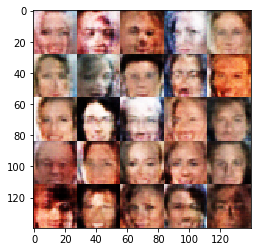

Epoch 1/1... batch 1600... Discriminator Loss: 0.6784... Generator Loss: 1.0873
Epoch 1/1... batch 1610... Discriminator Loss: 0.7349... Generator Loss: 1.0361
Epoch 1/1... batch 1620... Discriminator Loss: 0.7820... Generator Loss: 0.9750
Epoch 1/1... batch 1630... Discriminator Loss: 1.1957... Generator Loss: 0.5711
Epoch 1/1... batch 1640... Discriminator Loss: 0.7503... Generator Loss: 1.8660
Epoch 1/1... batch 1650... Discriminator Loss: 0.9345... Generator Loss: 0.7505
Epoch 1/1... batch 1660... Discriminator Loss: 1.3346... Generator Loss: 0.9687
Epoch 1/1... batch 1670... Discriminator Loss: 0.7515... Generator Loss: 0.8722
Epoch 1/1... batch 1680... Discriminator Loss: 1.0336... Generator Loss: 0.8618
Epoch 1/1... batch 1690... Discriminator Loss: 0.9509... Generator Loss: 0.7629


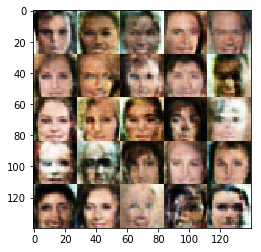

Epoch 1/1... batch 1700... Discriminator Loss: 0.8329... Generator Loss: 1.5503
Epoch 1/1... batch 1710... Discriminator Loss: 2.2548... Generator Loss: 0.1456
Epoch 1/1... batch 1720... Discriminator Loss: 0.8083... Generator Loss: 1.2060
Epoch 1/1... batch 1730... Discriminator Loss: 1.4469... Generator Loss: 0.5342
Epoch 1/1... batch 1740... Discriminator Loss: 0.7559... Generator Loss: 1.0830
Epoch 1/1... batch 1750... Discriminator Loss: 0.8401... Generator Loss: 0.9773
Epoch 1/1... batch 1760... Discriminator Loss: 0.6709... Generator Loss: 1.2226
Epoch 1/1... batch 1770... Discriminator Loss: 0.9016... Generator Loss: 0.8844
Epoch 1/1... batch 1780... Discriminator Loss: 1.0684... Generator Loss: 1.3012
Epoch 1/1... batch 1790... Discriminator Loss: 0.8824... Generator Loss: 1.1827


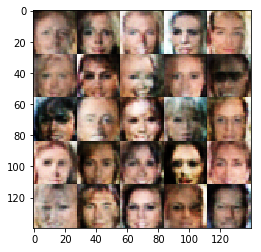

Epoch 1/1... batch 1800... Discriminator Loss: 0.8204... Generator Loss: 0.8497
Epoch 1/1... batch 1810... Discriminator Loss: 1.1752... Generator Loss: 0.5738
Epoch 1/1... batch 1820... Discriminator Loss: 1.6621... Generator Loss: 0.3271
Epoch 1/1... batch 1830... Discriminator Loss: 0.6837... Generator Loss: 1.7476
Epoch 1/1... batch 1840... Discriminator Loss: 0.7164... Generator Loss: 1.1561
Epoch 1/1... batch 1850... Discriminator Loss: 0.8995... Generator Loss: 1.1314
Epoch 1/1... batch 1860... Discriminator Loss: 1.9357... Generator Loss: 0.2097
Epoch 1/1... batch 1870... Discriminator Loss: 0.7488... Generator Loss: 1.0612
Epoch 1/1... batch 1880... Discriminator Loss: 0.7571... Generator Loss: 1.0531
Epoch 1/1... batch 1890... Discriminator Loss: 1.1746... Generator Loss: 0.5685


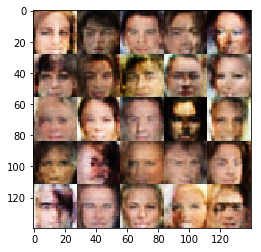

Epoch 1/1... batch 1900... Discriminator Loss: 1.3738... Generator Loss: 0.3834
Epoch 1/1... batch 1910... Discriminator Loss: 0.5848... Generator Loss: 1.2531
Epoch 1/1... batch 1920... Discriminator Loss: 1.3931... Generator Loss: 0.4273
Epoch 1/1... batch 1930... Discriminator Loss: 0.9342... Generator Loss: 1.3755
Epoch 1/1... batch 1940... Discriminator Loss: 1.1534... Generator Loss: 0.5306
Epoch 1/1... batch 1950... Discriminator Loss: 0.9334... Generator Loss: 0.8119
Epoch 1/1... batch 1960... Discriminator Loss: 1.0437... Generator Loss: 0.8013
Epoch 1/1... batch 1970... Discriminator Loss: 1.1315... Generator Loss: 0.6849
Epoch 1/1... batch 1980... Discriminator Loss: 1.5247... Generator Loss: 0.3237
Epoch 1/1... batch 1990... Discriminator Loss: 0.9836... Generator Loss: 0.6626


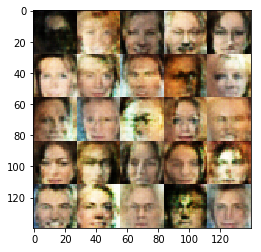

Epoch 1/1... batch 2000... Discriminator Loss: 1.0046... Generator Loss: 0.6664
Epoch 1/1... batch 2010... Discriminator Loss: 0.9410... Generator Loss: 0.7838
Epoch 1/1... batch 2020... Discriminator Loss: 1.3782... Generator Loss: 0.4198
Epoch 1/1... batch 2030... Discriminator Loss: 0.6560... Generator Loss: 1.4098
Epoch 1/1... batch 2040... Discriminator Loss: 1.0151... Generator Loss: 0.6278
Epoch 1/1... batch 2050... Discriminator Loss: 1.2736... Generator Loss: 0.6732
Epoch 1/1... batch 2060... Discriminator Loss: 0.9700... Generator Loss: 0.7772
Epoch 1/1... batch 2070... Discriminator Loss: 1.4434... Generator Loss: 1.0516
Epoch 1/1... batch 2080... Discriminator Loss: 1.1993... Generator Loss: 1.6915
Epoch 1/1... batch 2090... Discriminator Loss: 1.0192... Generator Loss: 1.0718


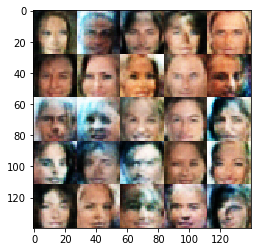

Epoch 1/1... batch 2100... Discriminator Loss: 0.9750... Generator Loss: 1.1650
Epoch 1/1... batch 2110... Discriminator Loss: 0.7804... Generator Loss: 1.0994
Epoch 1/1... batch 2120... Discriminator Loss: 1.5412... Generator Loss: 0.3278
Epoch 1/1... batch 2130... Discriminator Loss: 1.0513... Generator Loss: 0.6201
Epoch 1/1... batch 2140... Discriminator Loss: 0.7806... Generator Loss: 1.0499
Epoch 1/1... batch 2150... Discriminator Loss: 0.9995... Generator Loss: 0.9040
Epoch 1/1... batch 2160... Discriminator Loss: 0.9897... Generator Loss: 1.4102
Epoch 1/1... batch 2170... Discriminator Loss: 0.5045... Generator Loss: 1.5959
Epoch 1/1... batch 2180... Discriminator Loss: 0.5774... Generator Loss: 1.6694
Epoch 1/1... batch 2190... Discriminator Loss: 1.1286... Generator Loss: 0.5765


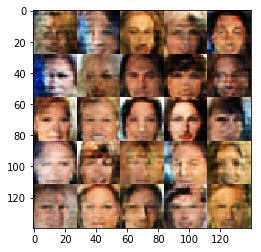

Epoch 1/1... batch 2200... Discriminator Loss: 0.8866... Generator Loss: 0.9047
Epoch 1/1... batch 2210... Discriminator Loss: 1.0885... Generator Loss: 0.7859
Epoch 1/1... batch 2220... Discriminator Loss: 1.3077... Generator Loss: 0.4024
Epoch 1/1... batch 2230... Discriminator Loss: 0.8954... Generator Loss: 0.9285
Epoch 1/1... batch 2240... Discriminator Loss: 1.0522... Generator Loss: 1.0313
Epoch 1/1... batch 2250... Discriminator Loss: 0.7377... Generator Loss: 1.2714
Epoch 1/1... batch 2260... Discriminator Loss: 0.9148... Generator Loss: 1.0742
Epoch 1/1... batch 2270... Discriminator Loss: 0.7593... Generator Loss: 1.1443
Epoch 1/1... batch 2280... Discriminator Loss: 1.0723... Generator Loss: 0.6569
Epoch 1/1... batch 2290... Discriminator Loss: 0.7011... Generator Loss: 1.3446


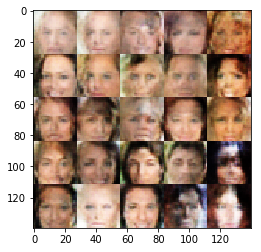

Epoch 1/1... batch 2300... Discriminator Loss: 1.0084... Generator Loss: 0.6733
Epoch 1/1... batch 2310... Discriminator Loss: 0.7411... Generator Loss: 1.0336
Epoch 1/1... batch 2320... Discriminator Loss: 0.5802... Generator Loss: 1.3515
Epoch 1/1... batch 2330... Discriminator Loss: 0.9833... Generator Loss: 1.0260
Epoch 1/1... batch 2340... Discriminator Loss: 0.8502... Generator Loss: 1.3793
Epoch 1/1... batch 2350... Discriminator Loss: 1.2949... Generator Loss: 0.5025
Epoch 1/1... batch 2360... Discriminator Loss: 0.9786... Generator Loss: 0.6172
Epoch 1/1... batch 2370... Discriminator Loss: 1.2546... Generator Loss: 0.4152
Epoch 1/1... batch 2380... Discriminator Loss: 1.0848... Generator Loss: 0.6119
Epoch 1/1... batch 2390... Discriminator Loss: 0.5514... Generator Loss: 2.0239


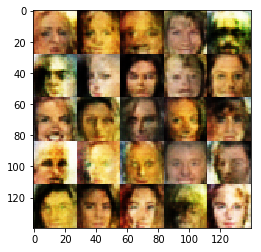

Epoch 1/1... batch 2400... Discriminator Loss: 0.8518... Generator Loss: 0.8105
Epoch 1/1... batch 2410... Discriminator Loss: 1.0127... Generator Loss: 0.6347
Epoch 1/1... batch 2420... Discriminator Loss: 1.1187... Generator Loss: 0.5707
Epoch 1/1... batch 2430... Discriminator Loss: 1.2196... Generator Loss: 0.5997
Epoch 1/1... batch 2440... Discriminator Loss: 0.8621... Generator Loss: 1.4115
Epoch 1/1... batch 2450... Discriminator Loss: 1.1227... Generator Loss: 0.5001
Epoch 1/1... batch 2460... Discriminator Loss: 1.0131... Generator Loss: 1.5806
Epoch 1/1... batch 2470... Discriminator Loss: 1.1373... Generator Loss: 0.4962
Epoch 1/1... batch 2480... Discriminator Loss: 1.0168... Generator Loss: 1.2598
Epoch 1/1... batch 2490... Discriminator Loss: 1.0621... Generator Loss: 2.2504


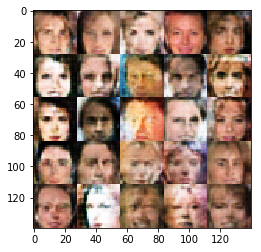

Epoch 1/1... batch 2500... Discriminator Loss: 1.1192... Generator Loss: 0.8844
Epoch 1/1... batch 2510... Discriminator Loss: 0.7712... Generator Loss: 0.9069
Epoch 1/1... batch 2520... Discriminator Loss: 0.9444... Generator Loss: 0.8436
Epoch 1/1... batch 2530... Discriminator Loss: 1.2218... Generator Loss: 0.5225
Epoch 1/1... batch 2540... Discriminator Loss: 0.8191... Generator Loss: 2.1078
Epoch 1/1... batch 2550... Discriminator Loss: 0.8692... Generator Loss: 0.7446
Epoch 1/1... batch 2560... Discriminator Loss: 1.0508... Generator Loss: 0.6502
Epoch 1/1... batch 2570... Discriminator Loss: 0.9370... Generator Loss: 0.7810
Epoch 1/1... batch 2580... Discriminator Loss: 1.2589... Generator Loss: 0.4378
Epoch 1/1... batch 2590... Discriminator Loss: 0.7712... Generator Loss: 1.0462


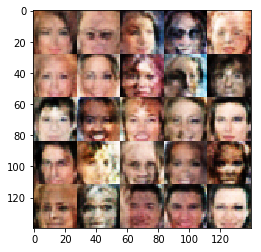

Epoch 1/1... batch 2600... Discriminator Loss: 1.1161... Generator Loss: 0.7588
Epoch 1/1... batch 2610... Discriminator Loss: 0.7217... Generator Loss: 1.1985
Epoch 1/1... batch 2620... Discriminator Loss: 1.3641... Generator Loss: 0.3859
Epoch 1/1... batch 2630... Discriminator Loss: 0.8359... Generator Loss: 1.0455
Epoch 1/1... batch 2640... Discriminator Loss: 1.0251... Generator Loss: 0.6213
Epoch 1/1... batch 2650... Discriminator Loss: 0.9880... Generator Loss: 0.7407
Epoch 1/1... batch 2660... Discriminator Loss: 1.1691... Generator Loss: 0.5126
Epoch 1/1... batch 2670... Discriminator Loss: 1.0432... Generator Loss: 0.6448
Epoch 1/1... batch 2680... Discriminator Loss: 1.0831... Generator Loss: 1.5450
Epoch 1/1... batch 2690... Discriminator Loss: 0.3893... Generator Loss: 1.9134


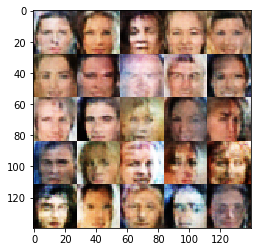

Epoch 1/1... batch 2700... Discriminator Loss: 1.4697... Generator Loss: 0.3892
Epoch 1/1... batch 2710... Discriminator Loss: 1.1266... Generator Loss: 0.5839
Epoch 1/1... batch 2720... Discriminator Loss: 1.1078... Generator Loss: 0.4674
Epoch 1/1... batch 2730... Discriminator Loss: 0.7957... Generator Loss: 1.1123
Epoch 1/1... batch 2740... Discriminator Loss: 1.1219... Generator Loss: 0.6323
Epoch 1/1... batch 2750... Discriminator Loss: 0.9074... Generator Loss: 1.1437
Epoch 1/1... batch 2760... Discriminator Loss: 1.4899... Generator Loss: 0.3379
Epoch 1/1... batch 2770... Discriminator Loss: 0.8273... Generator Loss: 1.0173
Epoch 1/1... batch 2780... Discriminator Loss: 1.0082... Generator Loss: 0.7084
Epoch 1/1... batch 2790... Discriminator Loss: 0.7298... Generator Loss: 1.3853


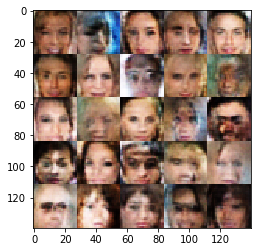

Epoch 1/1... batch 2800... Discriminator Loss: 0.6764... Generator Loss: 1.4529
Epoch 1/1... batch 2810... Discriminator Loss: 1.1183... Generator Loss: 1.2333
Epoch 1/1... batch 2820... Discriminator Loss: 0.8254... Generator Loss: 1.1099
Epoch 1/1... batch 2830... Discriminator Loss: 0.7788... Generator Loss: 1.2959
Epoch 1/1... batch 2840... Discriminator Loss: 0.9591... Generator Loss: 1.7810
Epoch 1/1... batch 2850... Discriminator Loss: 0.7880... Generator Loss: 1.1335
Epoch 1/1... batch 2860... Discriminator Loss: 1.1558... Generator Loss: 0.4870
Epoch 1/1... batch 2870... Discriminator Loss: 0.9900... Generator Loss: 0.6901
Epoch 1/1... batch 2880... Discriminator Loss: 1.0767... Generator Loss: 0.6153
Epoch 1/1... batch 2890... Discriminator Loss: 1.7878... Generator Loss: 1.7241


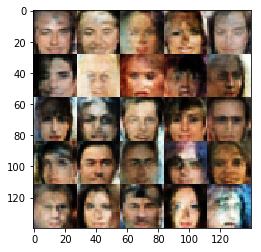

Epoch 1/1... batch 2900... Discriminator Loss: 1.0971... Generator Loss: 0.5338
Epoch 1/1... batch 2910... Discriminator Loss: 0.7204... Generator Loss: 1.2848
Epoch 1/1... batch 2920... Discriminator Loss: 1.3652... Generator Loss: 0.4332
Epoch 1/1... batch 2930... Discriminator Loss: 0.9962... Generator Loss: 0.6286
Epoch 1/1... batch 2940... Discriminator Loss: 0.6892... Generator Loss: 1.0673
Epoch 1/1... batch 2950... Discriminator Loss: 1.4401... Generator Loss: 0.3908
Epoch 1/1... batch 2960... Discriminator Loss: 0.8708... Generator Loss: 0.7973
Epoch 1/1... batch 2970... Discriminator Loss: 1.1382... Generator Loss: 0.5514
Epoch 1/1... batch 2980... Discriminator Loss: 1.1773... Generator Loss: 0.5119
Epoch 1/1... batch 2990... Discriminator Loss: 1.4412... Generator Loss: 0.3529


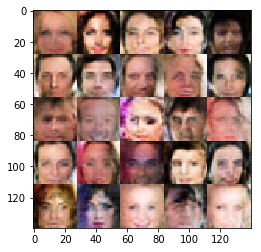

Epoch 1/1... batch 3000... Discriminator Loss: 1.1067... Generator Loss: 0.5600
Epoch 1/1... batch 3010... Discriminator Loss: 0.7995... Generator Loss: 1.1057
Epoch 1/1... batch 3020... Discriminator Loss: 0.9157... Generator Loss: 0.7028
Epoch 1/1... batch 3030... Discriminator Loss: 0.9627... Generator Loss: 0.7950
Epoch 1/1... batch 3040... Discriminator Loss: 0.8408... Generator Loss: 0.8578
Epoch 1/1... batch 3050... Discriminator Loss: 1.1711... Generator Loss: 0.5721
Epoch 1/1... batch 3060... Discriminator Loss: 0.9084... Generator Loss: 0.9377
Epoch 1/1... batch 3070... Discriminator Loss: 0.7285... Generator Loss: 1.2779
Epoch 1/1... batch 3080... Discriminator Loss: 0.9786... Generator Loss: 0.7197
Epoch 1/1... batch 3090... Discriminator Loss: 0.6996... Generator Loss: 1.0719


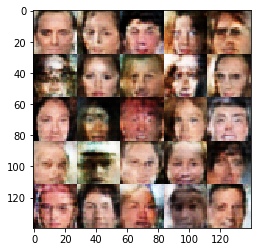

Epoch 1/1... batch 3100... Discriminator Loss: 0.9892... Generator Loss: 0.8105
Epoch 1/1... batch 3110... Discriminator Loss: 0.8068... Generator Loss: 1.6037
Epoch 1/1... batch 3120... Discriminator Loss: 0.9405... Generator Loss: 1.4115
Epoch 1/1... batch 3130... Discriminator Loss: 0.8926... Generator Loss: 0.7424
Epoch 1/1... batch 3140... Discriminator Loss: 1.4393... Generator Loss: 0.3401
Epoch 1/1... batch 3150... Discriminator Loss: 0.6491... Generator Loss: 1.3880
Epoch 1/1... batch 3160... Discriminator Loss: 0.5634... Generator Loss: 1.7353
Epoch 1/1... batch 3170... Discriminator Loss: 1.1831... Generator Loss: 0.5889
Epoch 1/1... batch 3180... Discriminator Loss: 0.9225... Generator Loss: 1.0912
Epoch 1/1... batch 3190... Discriminator Loss: 0.8837... Generator Loss: 1.2301


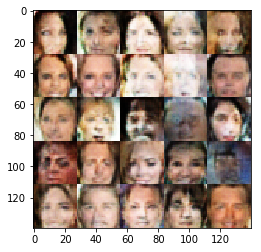

Epoch 1/1... batch 3200... Discriminator Loss: 1.0234... Generator Loss: 2.9261
Epoch 1/1... batch 3210... Discriminator Loss: 1.1364... Generator Loss: 0.5532
Epoch 1/1... batch 3220... Discriminator Loss: 0.9137... Generator Loss: 1.0369
Epoch 1/1... batch 3230... Discriminator Loss: 1.3375... Generator Loss: 0.3856
Epoch 1/1... batch 3240... Discriminator Loss: 1.0651... Generator Loss: 0.5807
Epoch 1/1... batch 3250... Discriminator Loss: 1.1643... Generator Loss: 0.4783
Epoch 1/1... batch 3260... Discriminator Loss: 0.8698... Generator Loss: 1.3295
Epoch 1/1... batch 3270... Discriminator Loss: 0.8325... Generator Loss: 0.9512
Epoch 1/1... batch 3280... Discriminator Loss: 0.7918... Generator Loss: 0.9781
Epoch 1/1... batch 3290... Discriminator Loss: 1.1071... Generator Loss: 0.5753


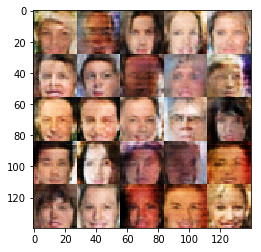

Epoch 1/1... batch 3300... Discriminator Loss: 0.6973... Generator Loss: 0.9728
Epoch 1/1... batch 3310... Discriminator Loss: 0.6787... Generator Loss: 1.2736
Epoch 1/1... batch 3320... Discriminator Loss: 0.6539... Generator Loss: 1.2047
Epoch 1/1... batch 3330... Discriminator Loss: 0.9329... Generator Loss: 0.9587
Epoch 1/1... batch 3340... Discriminator Loss: 0.9993... Generator Loss: 0.6466
Epoch 1/1... batch 3350... Discriminator Loss: 0.7923... Generator Loss: 0.9954
Epoch 1/1... batch 3360... Discriminator Loss: 0.8772... Generator Loss: 0.7566
Epoch 1/1... batch 3370... Discriminator Loss: 0.7432... Generator Loss: 1.3917
Epoch 1/1... batch 3380... Discriminator Loss: 1.2597... Generator Loss: 0.4454
Epoch 1/1... batch 3390... Discriminator Loss: 0.9825... Generator Loss: 0.6338


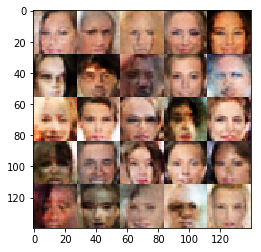

Epoch 1/1... batch 3400... Discriminator Loss: 1.1479... Generator Loss: 0.8405
Epoch 1/1... batch 3410... Discriminator Loss: 1.0365... Generator Loss: 0.5991
Epoch 1/1... batch 3420... Discriminator Loss: 1.2305... Generator Loss: 0.4634
Epoch 1/1... batch 3430... Discriminator Loss: 1.1117... Generator Loss: 0.5250
Epoch 1/1... batch 3440... Discriminator Loss: 0.9892... Generator Loss: 0.6788
Epoch 1/1... batch 3450... Discriminator Loss: 0.6133... Generator Loss: 1.1591
Epoch 1/1... batch 3460... Discriminator Loss: 1.0238... Generator Loss: 0.9632
Epoch 1/1... batch 3470... Discriminator Loss: 1.8094... Generator Loss: 0.2755
Epoch 1/1... batch 3480... Discriminator Loss: 0.6734... Generator Loss: 1.2802
Epoch 1/1... batch 3490... Discriminator Loss: 1.1395... Generator Loss: 0.5501


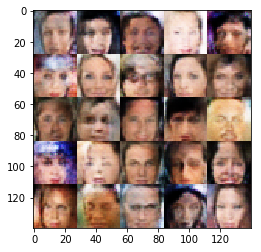

Epoch 1/1... batch 3500... Discriminator Loss: 2.0406... Generator Loss: 0.1856
Epoch 1/1... batch 3510... Discriminator Loss: 1.4293... Generator Loss: 0.3867
Epoch 1/1... batch 3520... Discriminator Loss: 1.3008... Generator Loss: 0.4981
Epoch 1/1... batch 3530... Discriminator Loss: 0.7837... Generator Loss: 1.0936
Epoch 1/1... batch 3540... Discriminator Loss: 0.8297... Generator Loss: 1.0255
Epoch 1/1... batch 3550... Discriminator Loss: 1.4430... Generator Loss: 2.2445
Epoch 1/1... batch 3560... Discriminator Loss: 0.9128... Generator Loss: 1.0199
Epoch 1/1... batch 3570... Discriminator Loss: 0.7803... Generator Loss: 1.0437
Epoch 1/1... batch 3580... Discriminator Loss: 0.7028... Generator Loss: 1.3219
Epoch 1/1... batch 3590... Discriminator Loss: 1.1886... Generator Loss: 0.5585


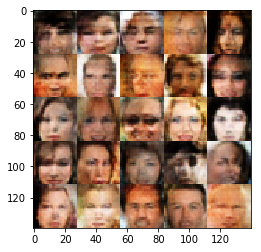

Epoch 1/1... batch 3600... Discriminator Loss: 1.0879... Generator Loss: 0.5851
Epoch 1/1... batch 3610... Discriminator Loss: 1.0565... Generator Loss: 1.5651
Epoch 1/1... batch 3620... Discriminator Loss: 0.9583... Generator Loss: 1.4293
Epoch 1/1... batch 3630... Discriminator Loss: 1.1706... Generator Loss: 0.5945
Epoch 1/1... batch 3640... Discriminator Loss: 0.9837... Generator Loss: 0.7714
Epoch 1/1... batch 3650... Discriminator Loss: 1.1084... Generator Loss: 0.7487
Epoch 1/1... batch 3660... Discriminator Loss: 0.8527... Generator Loss: 0.9737
Epoch 1/1... batch 3670... Discriminator Loss: 1.3705... Generator Loss: 0.3942
Epoch 1/1... batch 3680... Discriminator Loss: 0.8716... Generator Loss: 0.8150
Epoch 1/1... batch 3690... Discriminator Loss: 1.3045... Generator Loss: 0.4956


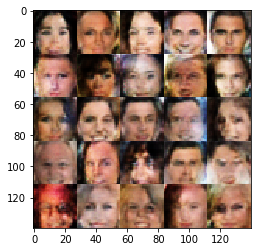

Epoch 1/1... batch 3700... Discriminator Loss: 1.0417... Generator Loss: 0.6932
Epoch 1/1... batch 3710... Discriminator Loss: 1.1751... Generator Loss: 1.3169
Epoch 1/1... batch 3720... Discriminator Loss: 0.9990... Generator Loss: 0.6146
Epoch 1/1... batch 3730... Discriminator Loss: 0.4566... Generator Loss: 1.5373
Epoch 1/1... batch 3740... Discriminator Loss: 0.8088... Generator Loss: 1.0707
Epoch 1/1... batch 3750... Discriminator Loss: 0.7859... Generator Loss: 0.9810
Epoch 1/1... batch 3760... Discriminator Loss: 1.0567... Generator Loss: 0.7168
Epoch 1/1... batch 3770... Discriminator Loss: 1.2879... Generator Loss: 0.4449
Epoch 1/1... batch 3780... Discriminator Loss: 0.9723... Generator Loss: 0.7823
Epoch 1/1... batch 3790... Discriminator Loss: 0.6759... Generator Loss: 1.1079


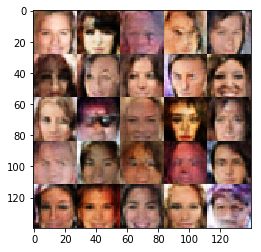

Epoch 1/1... batch 3800... Discriminator Loss: 0.7151... Generator Loss: 1.0231
Epoch 1/1... batch 3810... Discriminator Loss: 0.3993... Generator Loss: 2.0266
Epoch 1/1... batch 3820... Discriminator Loss: 0.6765... Generator Loss: 1.1849
Epoch 1/1... batch 3830... Discriminator Loss: 1.4350... Generator Loss: 0.3499
Epoch 1/1... batch 3840... Discriminator Loss: 0.7284... Generator Loss: 1.4688
Epoch 1/1... batch 3850... Discriminator Loss: 1.2912... Generator Loss: 0.3925
Epoch 1/1... batch 3860... Discriminator Loss: 1.1691... Generator Loss: 0.5554
Epoch 1/1... batch 3870... Discriminator Loss: 0.6956... Generator Loss: 0.9385
Epoch 1/1... batch 3880... Discriminator Loss: 0.5773... Generator Loss: 1.2091
Epoch 1/1... batch 3890... Discriminator Loss: 1.0221... Generator Loss: 0.6622


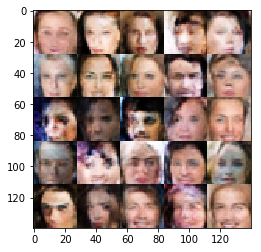

Epoch 1/1... batch 3900... Discriminator Loss: 0.9836... Generator Loss: 0.6700
Epoch 1/1... batch 3910... Discriminator Loss: 0.5623... Generator Loss: 1.4608
Epoch 1/1... batch 3920... Discriminator Loss: 1.0411... Generator Loss: 0.8576
Epoch 1/1... batch 3930... Discriminator Loss: 0.5925... Generator Loss: 1.4282
Epoch 1/1... batch 3940... Discriminator Loss: 1.6614... Generator Loss: 0.2954
Epoch 1/1... batch 3950... Discriminator Loss: 1.4369... Generator Loss: 0.3867
Epoch 1/1... batch 3960... Discriminator Loss: 1.3526... Generator Loss: 0.4020
Epoch 1/1... batch 3970... Discriminator Loss: 0.9045... Generator Loss: 0.8057
Epoch 1/1... batch 3980... Discriminator Loss: 1.2376... Generator Loss: 0.5610
Epoch 1/1... batch 3990... Discriminator Loss: 0.9402... Generator Loss: 0.7504


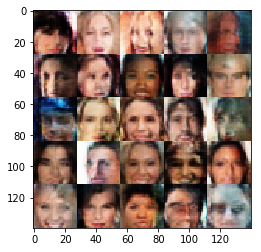

Epoch 1/1... batch 4000... Discriminator Loss: 1.4249... Generator Loss: 0.3781
Epoch 1/1... batch 4010... Discriminator Loss: 0.9540... Generator Loss: 0.7293
Epoch 1/1... batch 4020... Discriminator Loss: 0.9599... Generator Loss: 1.8552
Epoch 1/1... batch 4030... Discriminator Loss: 1.1343... Generator Loss: 0.5330
Epoch 1/1... batch 4040... Discriminator Loss: 0.8399... Generator Loss: 0.7805
Epoch 1/1... batch 4050... Discriminator Loss: 0.6864... Generator Loss: 1.5359
Epoch 1/1... batch 4060... Discriminator Loss: 0.8560... Generator Loss: 0.8745
Epoch 1/1... batch 4070... Discriminator Loss: 0.7841... Generator Loss: 1.3076
Epoch 1/1... batch 4080... Discriminator Loss: 1.4037... Generator Loss: 0.3847
Epoch 1/1... batch 4090... Discriminator Loss: 0.8120... Generator Loss: 0.9665


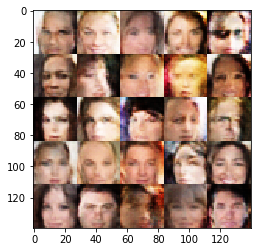

Epoch 1/1... batch 4100... Discriminator Loss: 1.0632... Generator Loss: 0.6441
Epoch 1/1... batch 4110... Discriminator Loss: 1.0021... Generator Loss: 0.8458
Epoch 1/1... batch 4120... Discriminator Loss: 0.7837... Generator Loss: 1.1951
Epoch 1/1... batch 4130... Discriminator Loss: 0.6413... Generator Loss: 1.1603
Epoch 1/1... batch 4140... Discriminator Loss: 0.9914... Generator Loss: 1.2063
Epoch 1/1... batch 4150... Discriminator Loss: 1.6440... Generator Loss: 0.3120
Epoch 1/1... batch 4160... Discriminator Loss: 0.9240... Generator Loss: 0.7468
Epoch 1/1... batch 4170... Discriminator Loss: 0.9655... Generator Loss: 0.9676
Epoch 1/1... batch 4180... Discriminator Loss: 0.8186... Generator Loss: 0.9753
Epoch 1/1... batch 4190... Discriminator Loss: 0.8511... Generator Loss: 0.8954


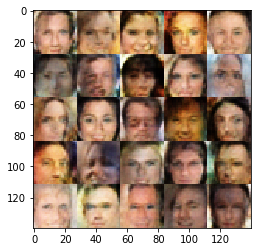

Epoch 1/1... batch 4200... Discriminator Loss: 1.5794... Generator Loss: 0.3242
Epoch 1/1... batch 4210... Discriminator Loss: 1.0395... Generator Loss: 0.6197
Epoch 1/1... batch 4220... Discriminator Loss: 1.0005... Generator Loss: 0.7223
Epoch 1/1... batch 4230... Discriminator Loss: 1.1465... Generator Loss: 0.5702
Epoch 1/1... batch 4240... Discriminator Loss: 0.7324... Generator Loss: 0.9576
Epoch 1/1... batch 4250... Discriminator Loss: 1.5456... Generator Loss: 0.3119
Epoch 1/1... batch 4260... Discriminator Loss: 1.0456... Generator Loss: 0.6293
Epoch 1/1... batch 4270... Discriminator Loss: 0.8823... Generator Loss: 1.4575
Epoch 1/1... batch 4280... Discriminator Loss: 0.8018... Generator Loss: 0.9830
Epoch 1/1... batch 4290... Discriminator Loss: 1.0392... Generator Loss: 0.9859


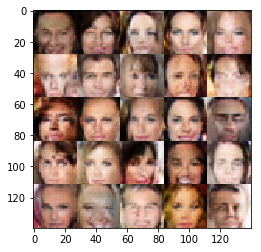

Epoch 1/1... batch 4300... Discriminator Loss: 0.7764... Generator Loss: 1.0164
Epoch 1/1... batch 4310... Discriminator Loss: 1.1487... Generator Loss: 0.5730
Epoch 1/1... batch 4320... Discriminator Loss: 1.4489... Generator Loss: 0.4305
Epoch 1/1... batch 4330... Discriminator Loss: 1.4160... Generator Loss: 0.3740
Epoch 1/1... batch 4340... Discriminator Loss: 1.5769... Generator Loss: 0.3106
Epoch 1/1... batch 4350... Discriminator Loss: 0.7482... Generator Loss: 1.0611
Epoch 1/1... batch 4360... Discriminator Loss: 0.8970... Generator Loss: 0.9537
Epoch 1/1... batch 4370... Discriminator Loss: 1.1889... Generator Loss: 1.8274
Epoch 1/1... batch 4380... Discriminator Loss: 1.0757... Generator Loss: 0.5936
Epoch 1/1... batch 4390... Discriminator Loss: 0.7528... Generator Loss: 1.6378


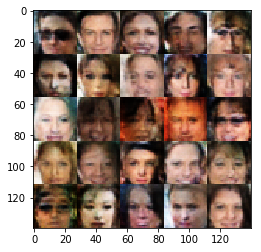

Epoch 1/1... batch 4400... Discriminator Loss: 0.8588... Generator Loss: 0.8353
Epoch 1/1... batch 4410... Discriminator Loss: 1.0559... Generator Loss: 0.6164
Epoch 1/1... batch 4420... Discriminator Loss: 1.3618... Generator Loss: 0.5360
Epoch 1/1... batch 4430... Discriminator Loss: 0.7790... Generator Loss: 1.0526
Epoch 1/1... batch 4440... Discriminator Loss: 1.1719... Generator Loss: 0.6028
Epoch 1/1... batch 4450... Discriminator Loss: 0.9776... Generator Loss: 0.7411
Epoch 1/1... batch 4460... Discriminator Loss: 0.6873... Generator Loss: 1.4381
Epoch 1/1... batch 4470... Discriminator Loss: 0.5907... Generator Loss: 1.1627
Epoch 1/1... batch 4480... Discriminator Loss: 1.3498... Generator Loss: 0.4983
Epoch 1/1... batch 4490... Discriminator Loss: 0.9709... Generator Loss: 0.7916


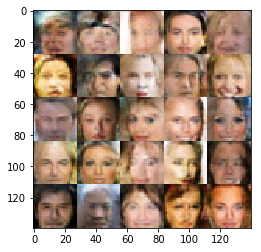

Epoch 1/1... batch 4500... Discriminator Loss: 0.7248... Generator Loss: 1.0546
Epoch 1/1... batch 4510... Discriminator Loss: 1.1277... Generator Loss: 0.6017
Epoch 1/1... batch 4520... Discriminator Loss: 0.8109... Generator Loss: 0.8822
Epoch 1/1... batch 4530... Discriminator Loss: 0.7427... Generator Loss: 0.9281
Epoch 1/1... batch 4540... Discriminator Loss: 0.7585... Generator Loss: 0.9806
Epoch 1/1... batch 4550... Discriminator Loss: 0.9977... Generator Loss: 0.8909
Epoch 1/1... batch 4560... Discriminator Loss: 0.5426... Generator Loss: 1.3172
Epoch 1/1... batch 4570... Discriminator Loss: 0.7850... Generator Loss: 0.8143
Epoch 1/1... batch 4580... Discriminator Loss: 1.4941... Generator Loss: 0.3239
Epoch 1/1... batch 4590... Discriminator Loss: 1.3367... Generator Loss: 0.4308


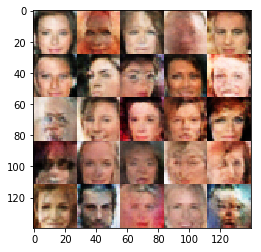

Epoch 1/1... batch 4600... Discriminator Loss: 1.5458... Generator Loss: 0.3251
Epoch 1/1... batch 4610... Discriminator Loss: 1.2087... Generator Loss: 0.5012
Epoch 1/1... batch 4620... Discriminator Loss: 0.7248... Generator Loss: 0.9353
Epoch 1/1... batch 4630... Discriminator Loss: 2.7232... Generator Loss: 0.0890
Epoch 1/1... batch 4640... Discriminator Loss: 0.9105... Generator Loss: 1.0711
Epoch 1/1... batch 4650... Discriminator Loss: 1.1390... Generator Loss: 0.9113
Epoch 1/1... batch 4660... Discriminator Loss: 0.7585... Generator Loss: 1.0376
Epoch 1/1... batch 4670... Discriminator Loss: 0.9819... Generator Loss: 0.7629
Epoch 1/1... batch 4680... Discriminator Loss: 0.7835... Generator Loss: 1.2575
Epoch 1/1... batch 4690... Discriminator Loss: 0.6890... Generator Loss: 1.7271


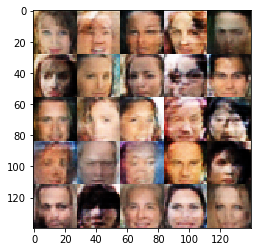

Epoch 1/1... batch 4700... Discriminator Loss: 1.9857... Generator Loss: 0.1842
Epoch 1/1... batch 4710... Discriminator Loss: 1.1798... Generator Loss: 0.7915
Epoch 1/1... batch 4720... Discriminator Loss: 0.7531... Generator Loss: 1.0097
Epoch 1/1... batch 4730... Discriminator Loss: 0.7867... Generator Loss: 0.9090
Epoch 1/1... batch 4740... Discriminator Loss: 0.8784... Generator Loss: 1.4572
Epoch 1/1... batch 4750... Discriminator Loss: 0.9007... Generator Loss: 1.2960
Epoch 1/1... batch 4760... Discriminator Loss: 0.9687... Generator Loss: 0.6799
Epoch 1/1... batch 4770... Discriminator Loss: 0.8752... Generator Loss: 0.8887
Epoch 1/1... batch 4780... Discriminator Loss: 0.8942... Generator Loss: 0.7326
Epoch 1/1... batch 4790... Discriminator Loss: 1.5636... Generator Loss: 0.3382


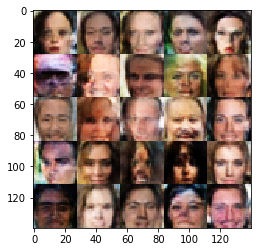

Epoch 1/1... batch 4800... Discriminator Loss: 1.2447... Generator Loss: 0.4940
Epoch 1/1... batch 4810... Discriminator Loss: 0.9167... Generator Loss: 0.7135
Epoch 1/1... batch 4820... Discriminator Loss: 1.1919... Generator Loss: 0.5080
Epoch 1/1... batch 4830... Discriminator Loss: 0.8167... Generator Loss: 0.9152
Epoch 1/1... batch 4840... Discriminator Loss: 0.9245... Generator Loss: 0.7355
Epoch 1/1... batch 4850... Discriminator Loss: 0.7941... Generator Loss: 0.8531
Epoch 1/1... batch 4860... Discriminator Loss: 1.1511... Generator Loss: 0.6945
Epoch 1/1... batch 4870... Discriminator Loss: 0.8514... Generator Loss: 0.8748
Epoch 1/1... batch 4880... Discriminator Loss: 1.1509... Generator Loss: 0.5222
Epoch 1/1... batch 4890... Discriminator Loss: 0.7226... Generator Loss: 1.0629


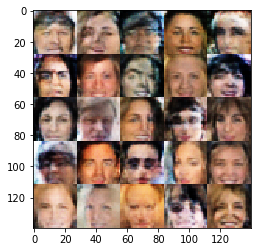

Epoch 1/1... batch 4900... Discriminator Loss: 0.4442... Generator Loss: 1.4752
Epoch 1/1... batch 4910... Discriminator Loss: 1.7373... Generator Loss: 3.1113
Epoch 1/1... batch 4920... Discriminator Loss: 0.8090... Generator Loss: 1.1346
Epoch 1/1... batch 4930... Discriminator Loss: 0.7670... Generator Loss: 0.8665
Epoch 1/1... batch 4940... Discriminator Loss: 0.9049... Generator Loss: 1.0162
Epoch 1/1... batch 4950... Discriminator Loss: 0.8367... Generator Loss: 0.8957
Epoch 1/1... batch 4960... Discriminator Loss: 1.0300... Generator Loss: 0.6112
Epoch 1/1... batch 4970... Discriminator Loss: 1.0591... Generator Loss: 0.8079
Epoch 1/1... batch 4980... Discriminator Loss: 1.1597... Generator Loss: 0.4763
Epoch 1/1... batch 4990... Discriminator Loss: 0.7292... Generator Loss: 1.3968


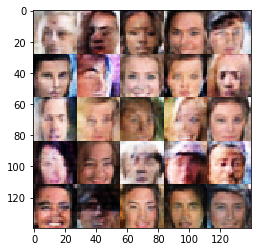

Epoch 1/1... batch 5000... Discriminator Loss: 1.4023... Generator Loss: 0.3693
Epoch 1/1... batch 5010... Discriminator Loss: 1.0958... Generator Loss: 2.0371
Epoch 1/1... batch 5020... Discriminator Loss: 0.8186... Generator Loss: 0.8911
Epoch 1/1... batch 5030... Discriminator Loss: 0.7832... Generator Loss: 0.9645
Epoch 1/1... batch 5040... Discriminator Loss: 1.1551... Generator Loss: 0.4960
Epoch 1/1... batch 5050... Discriminator Loss: 1.7369... Generator Loss: 0.2457
Epoch 1/1... batch 5060... Discriminator Loss: 1.3479... Generator Loss: 0.3961
Epoch 1/1... batch 5070... Discriminator Loss: 1.0264... Generator Loss: 0.6774
Epoch 1/1... batch 5080... Discriminator Loss: 0.9592... Generator Loss: 0.7031
Epoch 1/1... batch 5090... Discriminator Loss: 1.1211... Generator Loss: 0.6503


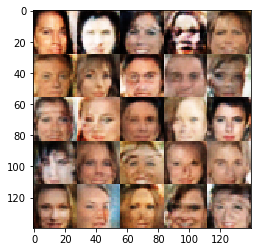

Epoch 1/1... batch 5100... Discriminator Loss: 0.7313... Generator Loss: 1.0367
Epoch 1/1... batch 5110... Discriminator Loss: 1.0964... Generator Loss: 1.8777
Epoch 1/1... batch 5120... Discriminator Loss: 1.0458... Generator Loss: 0.5763
Epoch 1/1... batch 5130... Discriminator Loss: 0.7801... Generator Loss: 1.3300
Epoch 1/1... batch 5140... Discriminator Loss: 0.7891... Generator Loss: 0.9474
Epoch 1/1... batch 5150... Discriminator Loss: 0.6939... Generator Loss: 1.3378
Epoch 1/1... batch 5160... Discriminator Loss: 1.0601... Generator Loss: 0.5836
Epoch 1/1... batch 5170... Discriminator Loss: 1.1914... Generator Loss: 0.6076
Epoch 1/1... batch 5180... Discriminator Loss: 0.9293... Generator Loss: 0.8854
Epoch 1/1... batch 5190... Discriminator Loss: 1.2353... Generator Loss: 1.1912


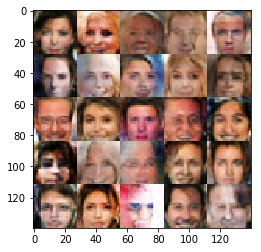

Epoch 1/1... batch 5200... Discriminator Loss: 0.9342... Generator Loss: 0.8818
Epoch 1/1... batch 5210... Discriminator Loss: 0.8803... Generator Loss: 0.8548
Epoch 1/1... batch 5220... Discriminator Loss: 1.0821... Generator Loss: 0.6343
Epoch 1/1... batch 5230... Discriminator Loss: 0.7039... Generator Loss: 1.0020
Epoch 1/1... batch 5240... Discriminator Loss: 0.6210... Generator Loss: 1.5619
Epoch 1/1... batch 5250... Discriminator Loss: 0.9136... Generator Loss: 0.6992
Epoch 1/1... batch 5260... Discriminator Loss: 1.1059... Generator Loss: 0.7823
Epoch 1/1... batch 5270... Discriminator Loss: 0.8363... Generator Loss: 0.9035
Epoch 1/1... batch 5280... Discriminator Loss: 0.7582... Generator Loss: 1.0557
Epoch 1/1... batch 5290... Discriminator Loss: 1.0388... Generator Loss: 2.7251


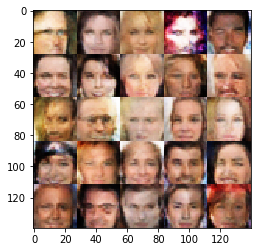

Epoch 1/1... batch 5300... Discriminator Loss: 1.3287... Generator Loss: 0.4002
Epoch 1/1... batch 5310... Discriminator Loss: 0.7403... Generator Loss: 1.1174
Epoch 1/1... batch 5320... Discriminator Loss: 1.2032... Generator Loss: 0.4510
Epoch 1/1... batch 5330... Discriminator Loss: 0.8072... Generator Loss: 0.9181
Epoch 1/1... batch 5340... Discriminator Loss: 0.7168... Generator Loss: 1.2284
Epoch 1/1... batch 5350... Discriminator Loss: 0.8777... Generator Loss: 0.9134
Epoch 1/1... batch 5360... Discriminator Loss: 0.8834... Generator Loss: 1.0857
Epoch 1/1... batch 5370... Discriminator Loss: 1.3696... Generator Loss: 0.4065
Epoch 1/1... batch 5380... Discriminator Loss: 0.6306... Generator Loss: 1.2762
Epoch 1/1... batch 5390... Discriminator Loss: 0.8877... Generator Loss: 0.7648


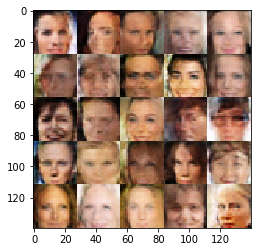

Epoch 1/1... batch 5400... Discriminator Loss: 0.5559... Generator Loss: 1.6407
Epoch 1/1... batch 5410... Discriminator Loss: 0.8370... Generator Loss: 1.6610
Epoch 1/1... batch 5420... Discriminator Loss: 1.1527... Generator Loss: 0.5603
Epoch 1/1... batch 5430... Discriminator Loss: 0.6058... Generator Loss: 1.3632
Epoch 1/1... batch 5440... Discriminator Loss: 1.0710... Generator Loss: 1.9760
Epoch 1/1... batch 5450... Discriminator Loss: 0.9597... Generator Loss: 0.9553
Epoch 1/1... batch 5460... Discriminator Loss: 0.9148... Generator Loss: 1.1734
Epoch 1/1... batch 5470... Discriminator Loss: 1.0368... Generator Loss: 0.6607
Epoch 1/1... batch 5480... Discriminator Loss: 0.9311... Generator Loss: 0.7629
Epoch 1/1... batch 5490... Discriminator Loss: 1.3808... Generator Loss: 0.3573


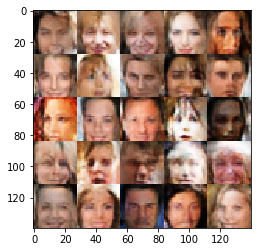

Epoch 1/1... batch 5500... Discriminator Loss: 0.9965... Generator Loss: 0.9043
Epoch 1/1... batch 5510... Discriminator Loss: 0.5341... Generator Loss: 1.9187
Epoch 1/1... batch 5520... Discriminator Loss: 0.9843... Generator Loss: 0.8634
Epoch 1/1... batch 5530... Discriminator Loss: 0.8233... Generator Loss: 1.6331
Epoch 1/1... batch 5540... Discriminator Loss: 1.0605... Generator Loss: 0.7075
Epoch 1/1... batch 5550... Discriminator Loss: 0.9441... Generator Loss: 0.6473
Epoch 1/1... batch 5560... Discriminator Loss: 1.1341... Generator Loss: 0.5301
Epoch 1/1... batch 5570... Discriminator Loss: 0.8780... Generator Loss: 0.7079
Epoch 1/1... batch 5580... Discriminator Loss: 0.9361... Generator Loss: 1.0480
Epoch 1/1... batch 5590... Discriminator Loss: 0.9589... Generator Loss: 1.1250


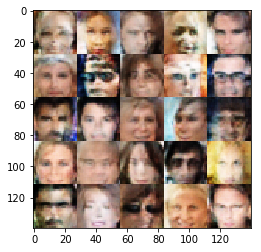

Epoch 1/1... batch 5600... Discriminator Loss: 1.3126... Generator Loss: 0.4479
Epoch 1/1... batch 5610... Discriminator Loss: 0.8885... Generator Loss: 1.1892
Epoch 1/1... batch 5620... Discriminator Loss: 0.7830... Generator Loss: 1.7490
Epoch 1/1... batch 5630... Discriminator Loss: 0.8346... Generator Loss: 0.9337
Epoch 1/1... batch 5640... Discriminator Loss: 0.6858... Generator Loss: 1.1700
Epoch 1/1... batch 5650... Discriminator Loss: 1.2572... Generator Loss: 0.4911
Epoch 1/1... batch 5660... Discriminator Loss: 0.7183... Generator Loss: 0.9232
Epoch 1/1... batch 5670... Discriminator Loss: 1.2914... Generator Loss: 0.4884
Epoch 1/1... batch 5680... Discriminator Loss: 1.0096... Generator Loss: 0.6182
Epoch 1/1... batch 5690... Discriminator Loss: 1.3159... Generator Loss: 0.4056


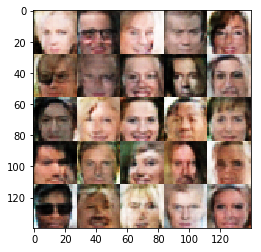

Epoch 1/1... batch 5700... Discriminator Loss: 1.1640... Generator Loss: 0.5595
Epoch 1/1... batch 5710... Discriminator Loss: 1.2228... Generator Loss: 0.4595
Epoch 1/1... batch 5720... Discriminator Loss: 1.1462... Generator Loss: 0.6935
Epoch 1/1... batch 5730... Discriminator Loss: 1.0131... Generator Loss: 0.7560
Epoch 1/1... batch 5740... Discriminator Loss: 1.0950... Generator Loss: 0.5997
Epoch 1/1... batch 5750... Discriminator Loss: 0.8970... Generator Loss: 0.8203
Epoch 1/1... batch 5760... Discriminator Loss: 0.8298... Generator Loss: 0.9355
Epoch 1/1... batch 5770... Discriminator Loss: 0.7755... Generator Loss: 1.1672
Epoch 1/1... batch 5780... Discriminator Loss: 0.6704... Generator Loss: 1.3779
Epoch 1/1... batch 5790... Discriminator Loss: 0.8767... Generator Loss: 0.7813


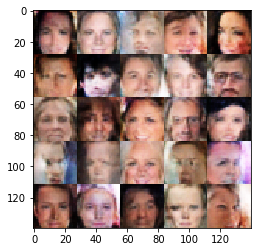

Epoch 1/1... batch 5800... Discriminator Loss: 0.9673... Generator Loss: 1.3206
Epoch 1/1... batch 5810... Discriminator Loss: 1.1535... Generator Loss: 0.5494
Epoch 1/1... batch 5820... Discriminator Loss: 1.0612... Generator Loss: 0.7716
Epoch 1/1... batch 5830... Discriminator Loss: 1.1091... Generator Loss: 0.6264
Epoch 1/1... batch 5840... Discriminator Loss: 1.4461... Generator Loss: 0.3809
Epoch 1/1... batch 5850... Discriminator Loss: 0.7851... Generator Loss: 0.9767
Epoch 1/1... batch 5860... Discriminator Loss: 0.6616... Generator Loss: 1.3292
Epoch 1/1... batch 5870... Discriminator Loss: 0.9343... Generator Loss: 0.7374
Epoch 1/1... batch 5880... Discriminator Loss: 0.9965... Generator Loss: 0.6077
Epoch 1/1... batch 5890... Discriminator Loss: 1.0764... Generator Loss: 0.8722


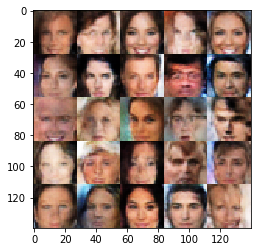

Epoch 1/1... batch 5900... Discriminator Loss: 0.9853... Generator Loss: 0.7084
Epoch 1/1... batch 5910... Discriminator Loss: 0.3802... Generator Loss: 1.7187
Epoch 1/1... batch 5920... Discriminator Loss: 1.2886... Generator Loss: 0.4420
Epoch 1/1... batch 5930... Discriminator Loss: 0.8827... Generator Loss: 0.7633
Epoch 1/1... batch 5940... Discriminator Loss: 1.0237... Generator Loss: 0.6322
Epoch 1/1... batch 5950... Discriminator Loss: 0.5379... Generator Loss: 1.4227
Epoch 1/1... batch 5960... Discriminator Loss: 0.5598... Generator Loss: 1.4417
Epoch 1/1... batch 5970... Discriminator Loss: 2.1680... Generator Loss: 3.0929
Epoch 1/1... batch 5980... Discriminator Loss: 0.5172... Generator Loss: 1.3787
Epoch 1/1... batch 5990... Discriminator Loss: 0.9274... Generator Loss: 0.7573


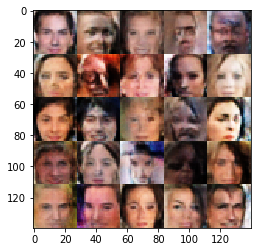

Epoch 1/1... batch 6000... Discriminator Loss: 1.0420... Generator Loss: 0.7617
Epoch 1/1... batch 6010... Discriminator Loss: 1.1371... Generator Loss: 0.5117
Epoch 1/1... batch 6020... Discriminator Loss: 0.8441... Generator Loss: 0.8387
Epoch 1/1... batch 6030... Discriminator Loss: 0.9576... Generator Loss: 0.7747
Epoch 1/1... batch 6040... Discriminator Loss: 0.6660... Generator Loss: 1.3865
Epoch 1/1... batch 6050... Discriminator Loss: 1.0307... Generator Loss: 0.6584
Epoch 1/1... batch 6060... Discriminator Loss: 0.8037... Generator Loss: 0.9733
Epoch 1/1... batch 6070... Discriminator Loss: 0.6853... Generator Loss: 0.8749
Epoch 1/1... batch 6080... Discriminator Loss: 1.0625... Generator Loss: 0.5940
Epoch 1/1... batch 6090... Discriminator Loss: 0.9360... Generator Loss: 0.8639


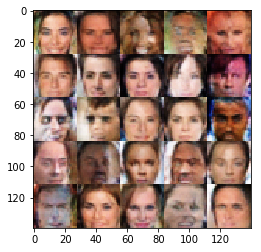

Epoch 1/1... batch 6100... Discriminator Loss: 0.8141... Generator Loss: 1.0841
Epoch 1/1... batch 6110... Discriminator Loss: 0.8594... Generator Loss: 1.2616
Epoch 1/1... batch 6120... Discriminator Loss: 1.0917... Generator Loss: 0.5804
Epoch 1/1... batch 6130... Discriminator Loss: 0.7249... Generator Loss: 1.8008
Epoch 1/1... batch 6140... Discriminator Loss: 0.9089... Generator Loss: 1.5766
Epoch 1/1... batch 6150... Discriminator Loss: 0.6634... Generator Loss: 1.0739
Epoch 1/1... batch 6160... Discriminator Loss: 1.1194... Generator Loss: 0.6448
Epoch 1/1... batch 6170... Discriminator Loss: 1.2895... Generator Loss: 0.3954
Epoch 1/1... batch 6180... Discriminator Loss: 1.0081... Generator Loss: 0.6416
Epoch 1/1... batch 6190... Discriminator Loss: 0.5744... Generator Loss: 1.2286


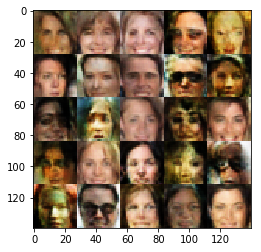

Epoch 1/1... batch 6200... Discriminator Loss: 0.7552... Generator Loss: 0.9741
Epoch 1/1... batch 6210... Discriminator Loss: 1.0066... Generator Loss: 1.4811
Epoch 1/1... batch 6220... Discriminator Loss: 0.8213... Generator Loss: 0.7888
Epoch 1/1... batch 6230... Discriminator Loss: 0.8154... Generator Loss: 0.9678
Epoch 1/1... batch 6240... Discriminator Loss: 0.8103... Generator Loss: 1.1020
Epoch 1/1... batch 6250... Discriminator Loss: 0.7863... Generator Loss: 1.5837
Epoch 1/1... batch 6260... Discriminator Loss: 0.8292... Generator Loss: 0.9070
Epoch 1/1... batch 6270... Discriminator Loss: 0.8248... Generator Loss: 1.0315
Epoch 1/1... batch 6280... Discriminator Loss: 1.6849... Generator Loss: 0.2627
Epoch 1/1... batch 6290... Discriminator Loss: 0.9751... Generator Loss: 0.8018


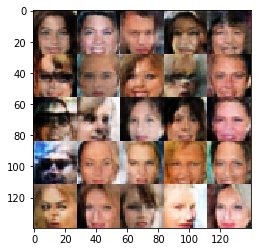

Epoch 1/1... batch 6300... Discriminator Loss: 0.7903... Generator Loss: 1.0461
Epoch 1/1... batch 6310... Discriminator Loss: 1.4403... Generator Loss: 0.3337
Epoch 1/1... batch 6320... Discriminator Loss: 1.5165... Generator Loss: 0.3846
Epoch 1/1... batch 6330... Discriminator Loss: 0.7653... Generator Loss: 0.9173


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。